In [1]:
import pandas as pd

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [3]:
%config InlineBackend.figure_format = 'retina'

In [48]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [68]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [7]:
# Another REF
# https://www.kaggle.com/code/harshjain123/time-series-arima-sarima/notebook

## Loading Dataset & Filtering

In [8]:
df = pd.read_csv("pedidos_magalu.csv", sep=',', date_parser='data')

In [9]:
df['data'] = pd.to_datetime(df['data'])

In [10]:
df.columns = ['date', 'orders']

## Converting to Timeseries

In [11]:
df = df.set_index('date')
timeseries = pd.Series(data=df['orders'])

## Data Health Checking

In [12]:
timeseries.isna().sum()

0

## First Plot

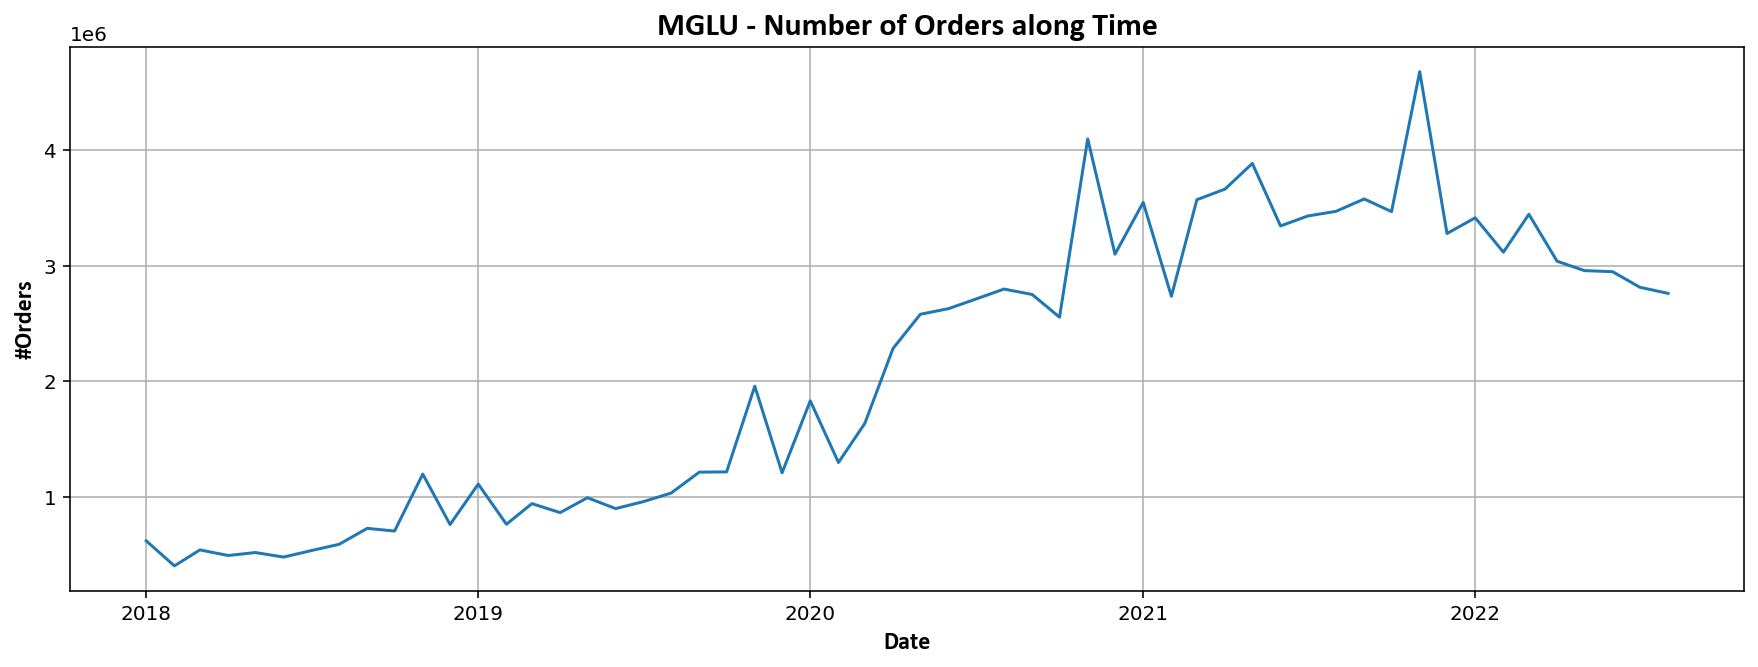

In [13]:
# # Para tirar a densidade do gráfico, exibe uma amostra de 10% do total
fig, ax = plt.subplots(ncols=1, figsize = (15,5))
hfont = {'fontname':'Calibri'}

sns.lineplot(data=timeseries, ax=ax, linestyle='-');
plt.title("MGLU - Number of Orders along Time", fontsize=16, fontdict=dict(weight='bold'), **hfont)
ax.set_xlabel("Date", fontsize=12, fontdict=dict(weight='bold'), **hfont);
ax.set_ylabel("#Orders", fontsize=12, fontdict=dict(weight='bold'), **hfont);
ax.grid()

## Multianual Stacked Plot

In [14]:
# !Deprecated
bianual_timeseries = (
    timeseries[(timeseries.index >= datetime(year=1998, month=1, day=1)) & 
               (timeseries.index <= datetime(year=2000, month=1, day=1))
              ]
)

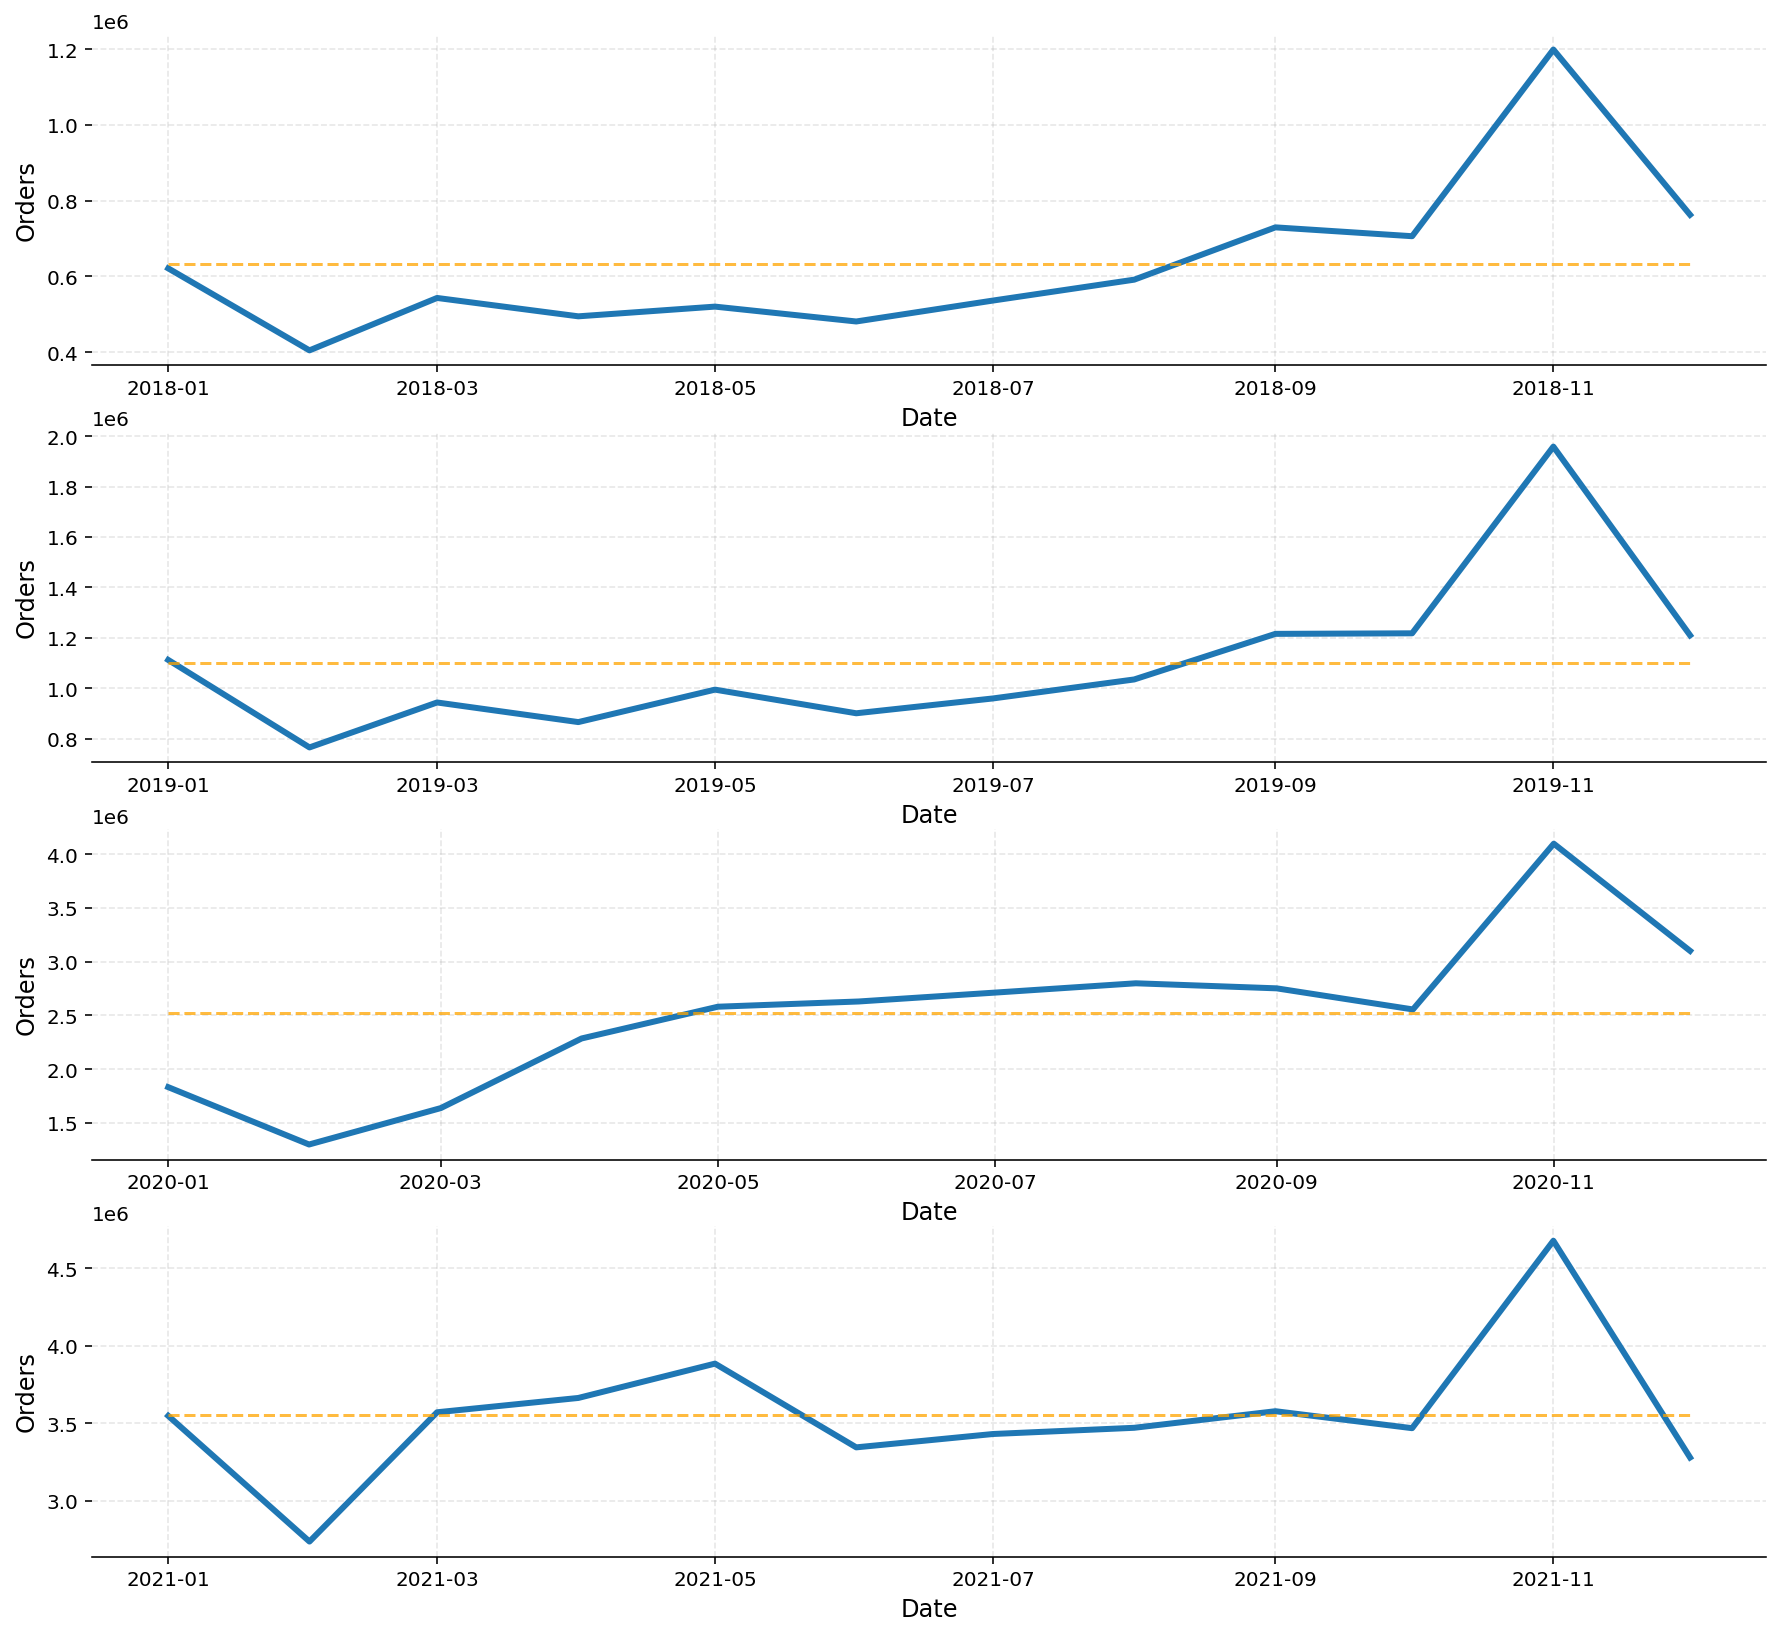

In [15]:
years = timeseries.index.year.unique().values

years = [2018, 2019, 2020, 2021]

fig, ax = plt.subplots(nrows=len(years), figsize = (15,14))

for i, y in enumerate(years):
    d = timeseries[(timeseries.index.year == y)]

    fit = sm.tsa.STL(d).fit()
    sns.lineplot(data=d, ax=ax[i], linestyle='-', linewidth=3);
    sns.lineplot(data=fit.trend, ax=ax[i], linestyle='--', alpha=.75, color='orange');
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xlabel("Date", fontsize=12)
    ax[i].set_ylabel("Orders", fontsize=12)
    ax[i].grid(linestyle='--', alpha=0.3);

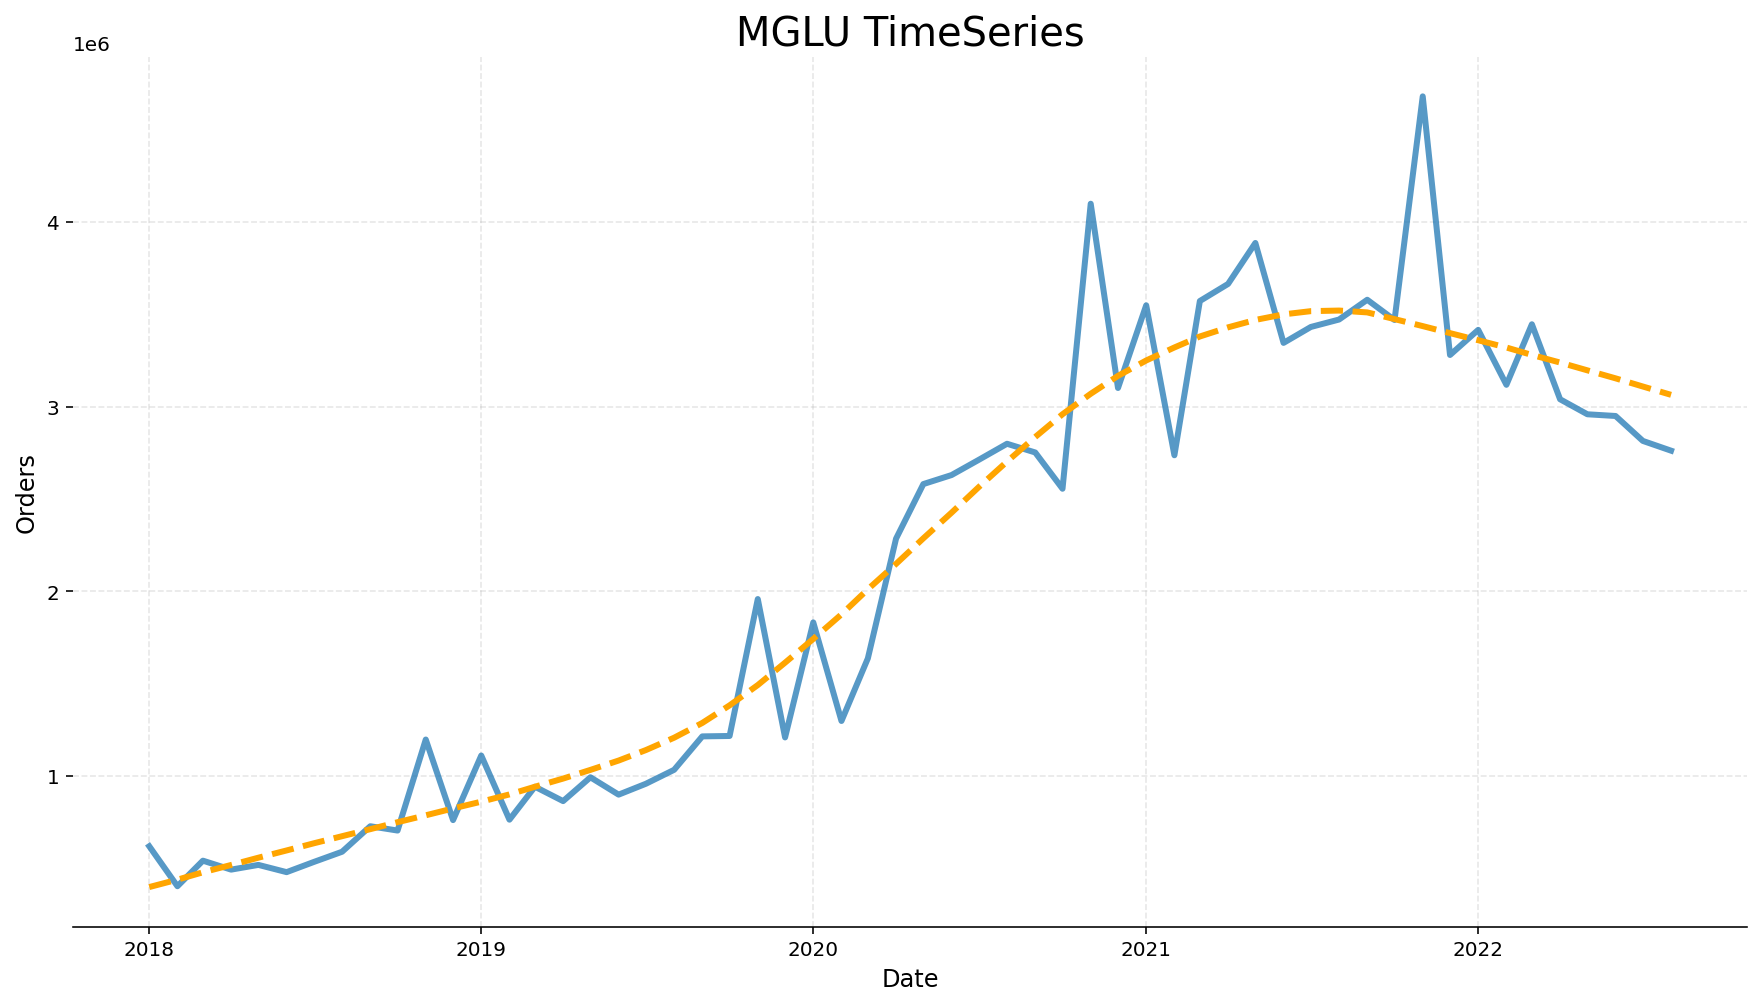

In [16]:
fig, ax = plt.subplots(ncols=1, figsize = (15,8))

fit = sm.tsa.STL(timeseries).fit()

plt.title("MGLU TimeSeries", fontsize=20)
sns.lineplot(data=timeseries, ax=ax, linestyle='-', alpha=.75, linewidth=3);
sns.lineplot(data=fit.trend, ax=ax, linestyle='--', color='orange', linewidth=3);
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Orders", fontsize=12)
ax.grid(linestyle='--', alpha=0.3);

## Ploting ACF

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

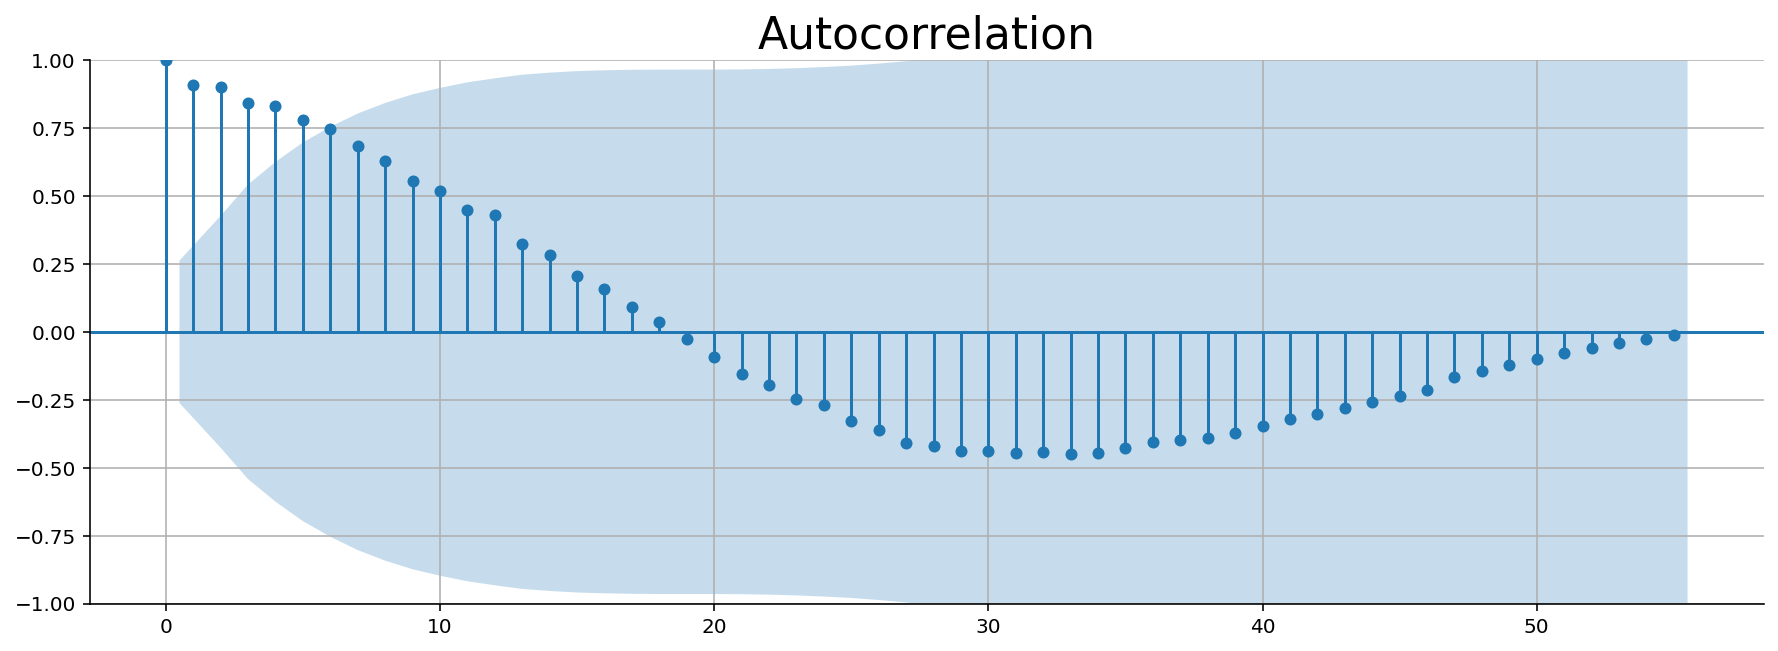

In [18]:
fig, ax = plt.subplots(ncols=1, figsize = (15,5))
plot_acf(timeseries, lags=55, ax=ax);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Autocorrelation", fontsize=22)
ax.grid()

## Getting the Differences

In [19]:
# Inbuilt function
diff_timeseries = timeseries.diff()

In [20]:
diff_timeseries = diff_timeseries.dropna()

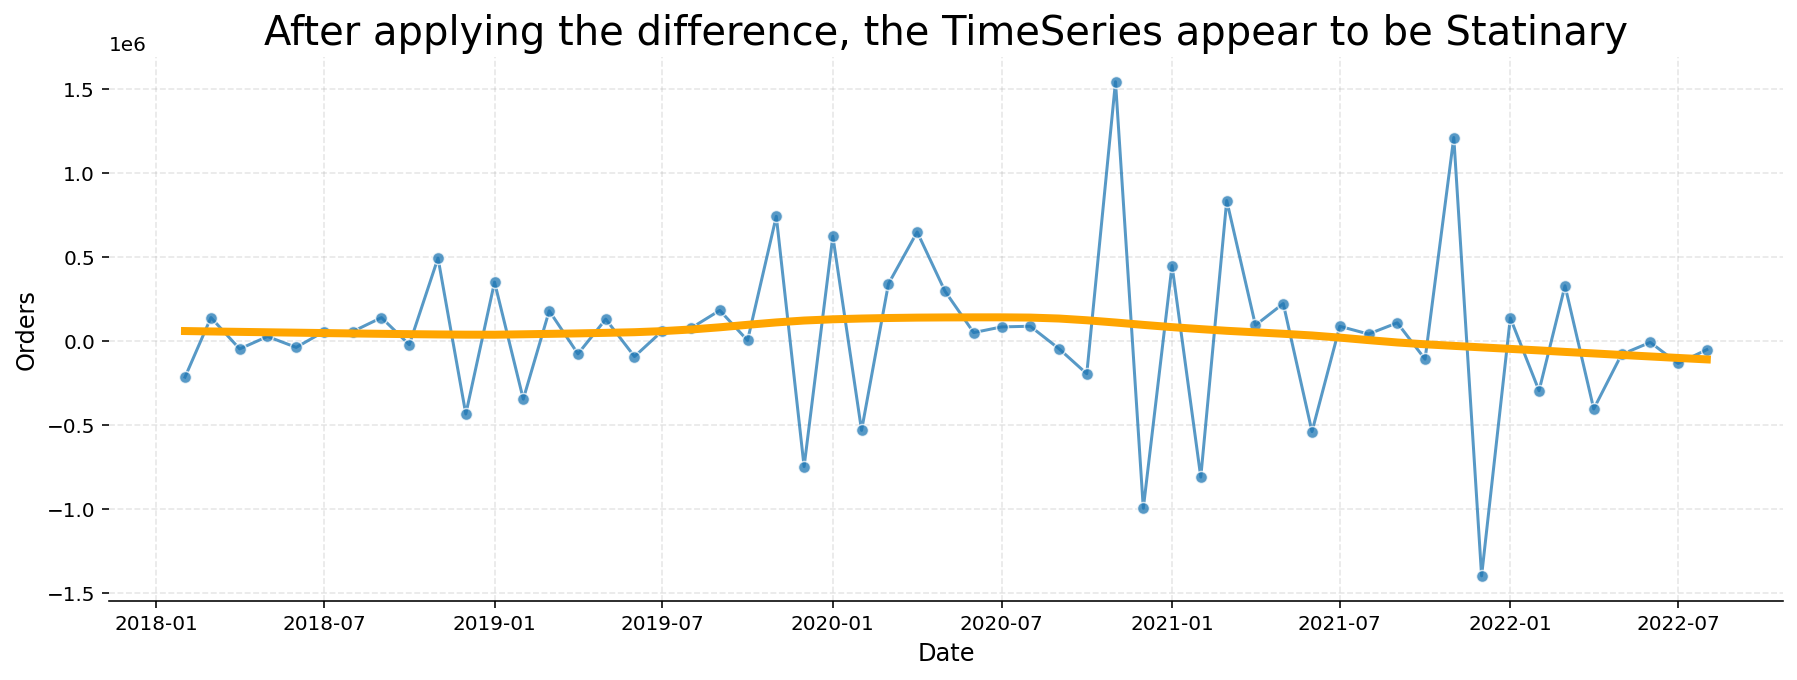

In [21]:
fig, ax = plt.subplots(ncols=1, figsize = (15,5))

sns.lineplot(data=diff_timeseries, ax=ax, linestyle='-', alpha=.75, marker='o');

fit = sm.tsa.STL(diff_timeseries).fit()

plt.title("After applying the difference, the TimeSeries appear to be Statinary", fontsize=20)
sns.lineplot(data=fit.trend, ax=ax, linestyle='-', color='orange', linewidth=4);
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Orders", fontsize=12)
ax.grid(linestyle='--', alpha=0.3);

In [22]:
# TODO: fix following plots aspect

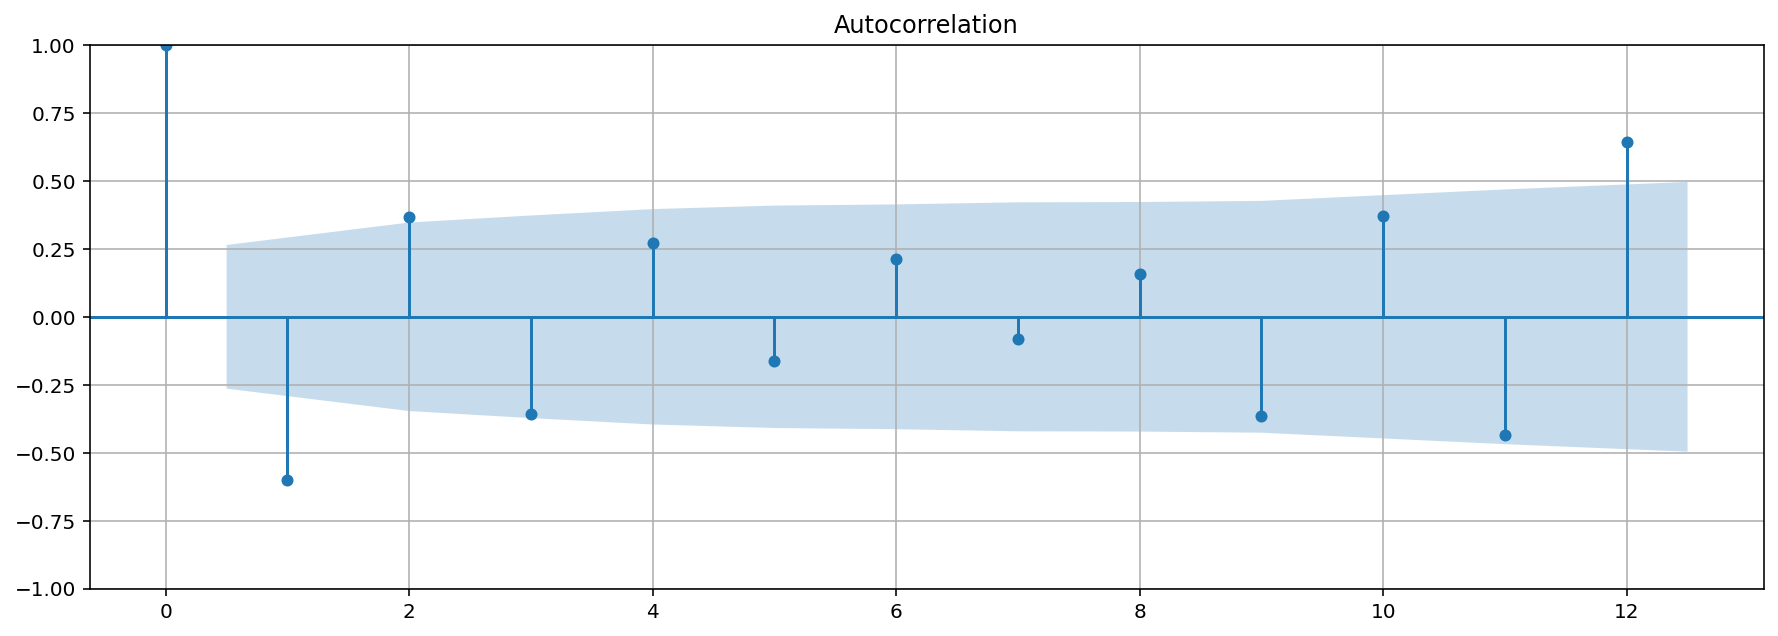

In [23]:
fig, ax = plt.subplots(ncols=1, figsize = (15,5))
plot_acf(diff_timeseries, lags=12, ax=ax);
ax.grid()

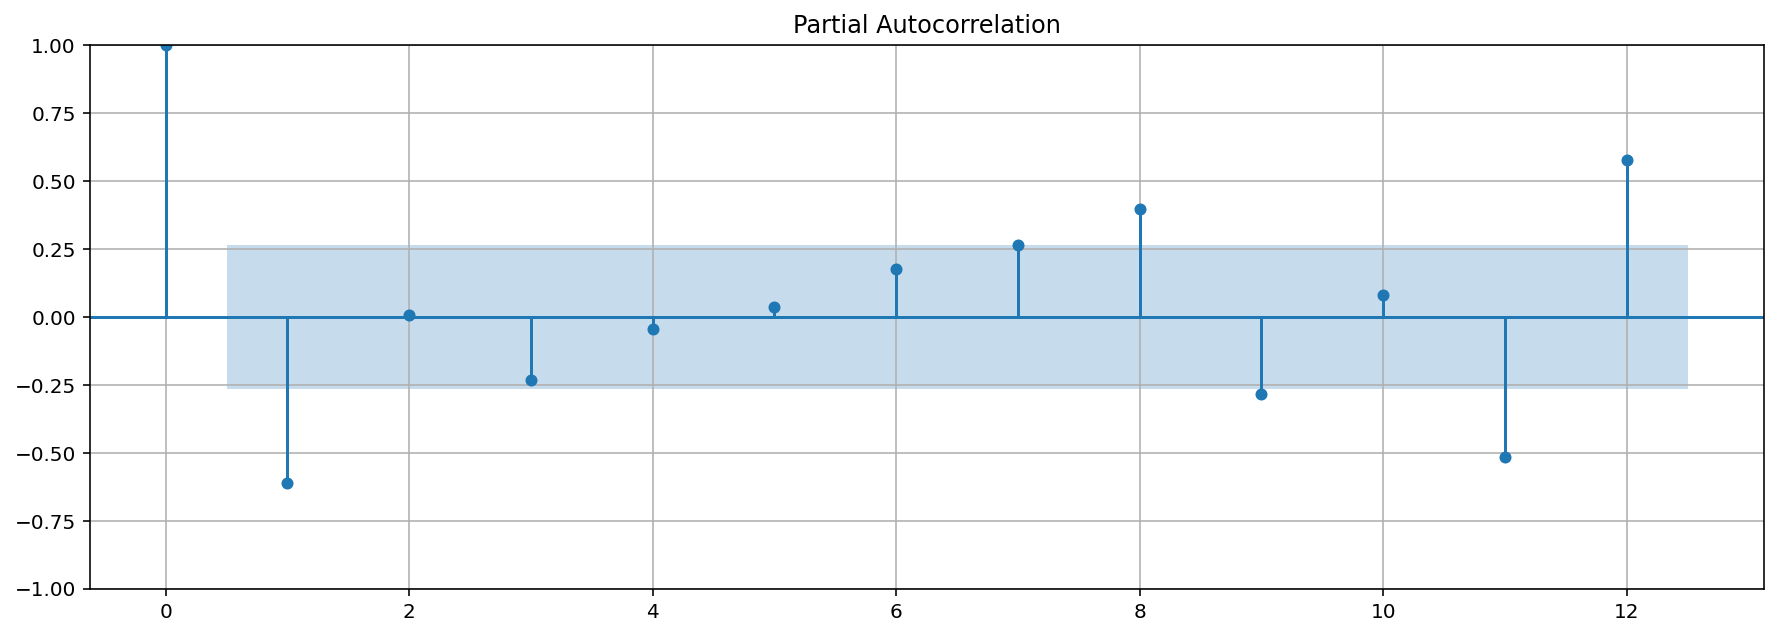

In [24]:
fig, ax = plt.subplots(ncols=1, figsize = (15,5))
plot_pacf(diff_timeseries, lags=12, ax=ax);
ax.grid()

## Testing Unitary Root - ADF

- **null hypothesis** -> THERE IS A UNIT ROOT
- **alt hypothesis** -> THERE IS A UNIT ROOT

The **null hypothesis** of the Augmented Dickey-Fuller is that there is a unit
root, with the alternative that there is no unit root. If the pvalue is
above a critical size, then we cannot reject that there is a unit root.

In [25]:
# calculate the stationarity of a random walk
from statsmodels.tsa.stattools import adfuller

def adf_testing(s):
    result = adfuller(s)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [26]:
adf_testing(timeseries)

ADF Statistic: -1.091629
p-value: 0.718399
Critical Values:
	1%: -3.589
	5%: -2.930
	10%: -2.603


    This is larger than all of the critical values at the 1%, 5%, and 10% confidence levels. Therefore, we can say that the time series does appear to be non-stationary with a low likelihood of the result being a statistical fluke.

In [27]:
adf_testing(diff_timeseries)

ADF Statistic: -0.267660
p-value: 0.929961
Critical Values:
	1%: -3.593
	5%: -2.932
	10%: -2.604


    This is larger than all of the critical values at the 1%, 5%, and 10% confidence levels. Therefore, we can say that the time series does appear to be non-stationary with a low likelihood of the result being a statistical fluke.

<hr style="height:3px">

# DECOMPOSING

- **LEVEL** The baseline value for the series if it were a straight line.

- **TREND** The optional and often linear increasing or decreasing behavior of the series over
time.

- **SEASONALITY** The optional repeating patterns or cycles of behavior over time.

- **NOISE** The optional variability in the observations that cannot be explained by the
model.


_All time series have a level, most have noise, and the trend and seasonality are optional._

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [29]:
result = seasonal_decompose(timeseries, model='additive', period=12)

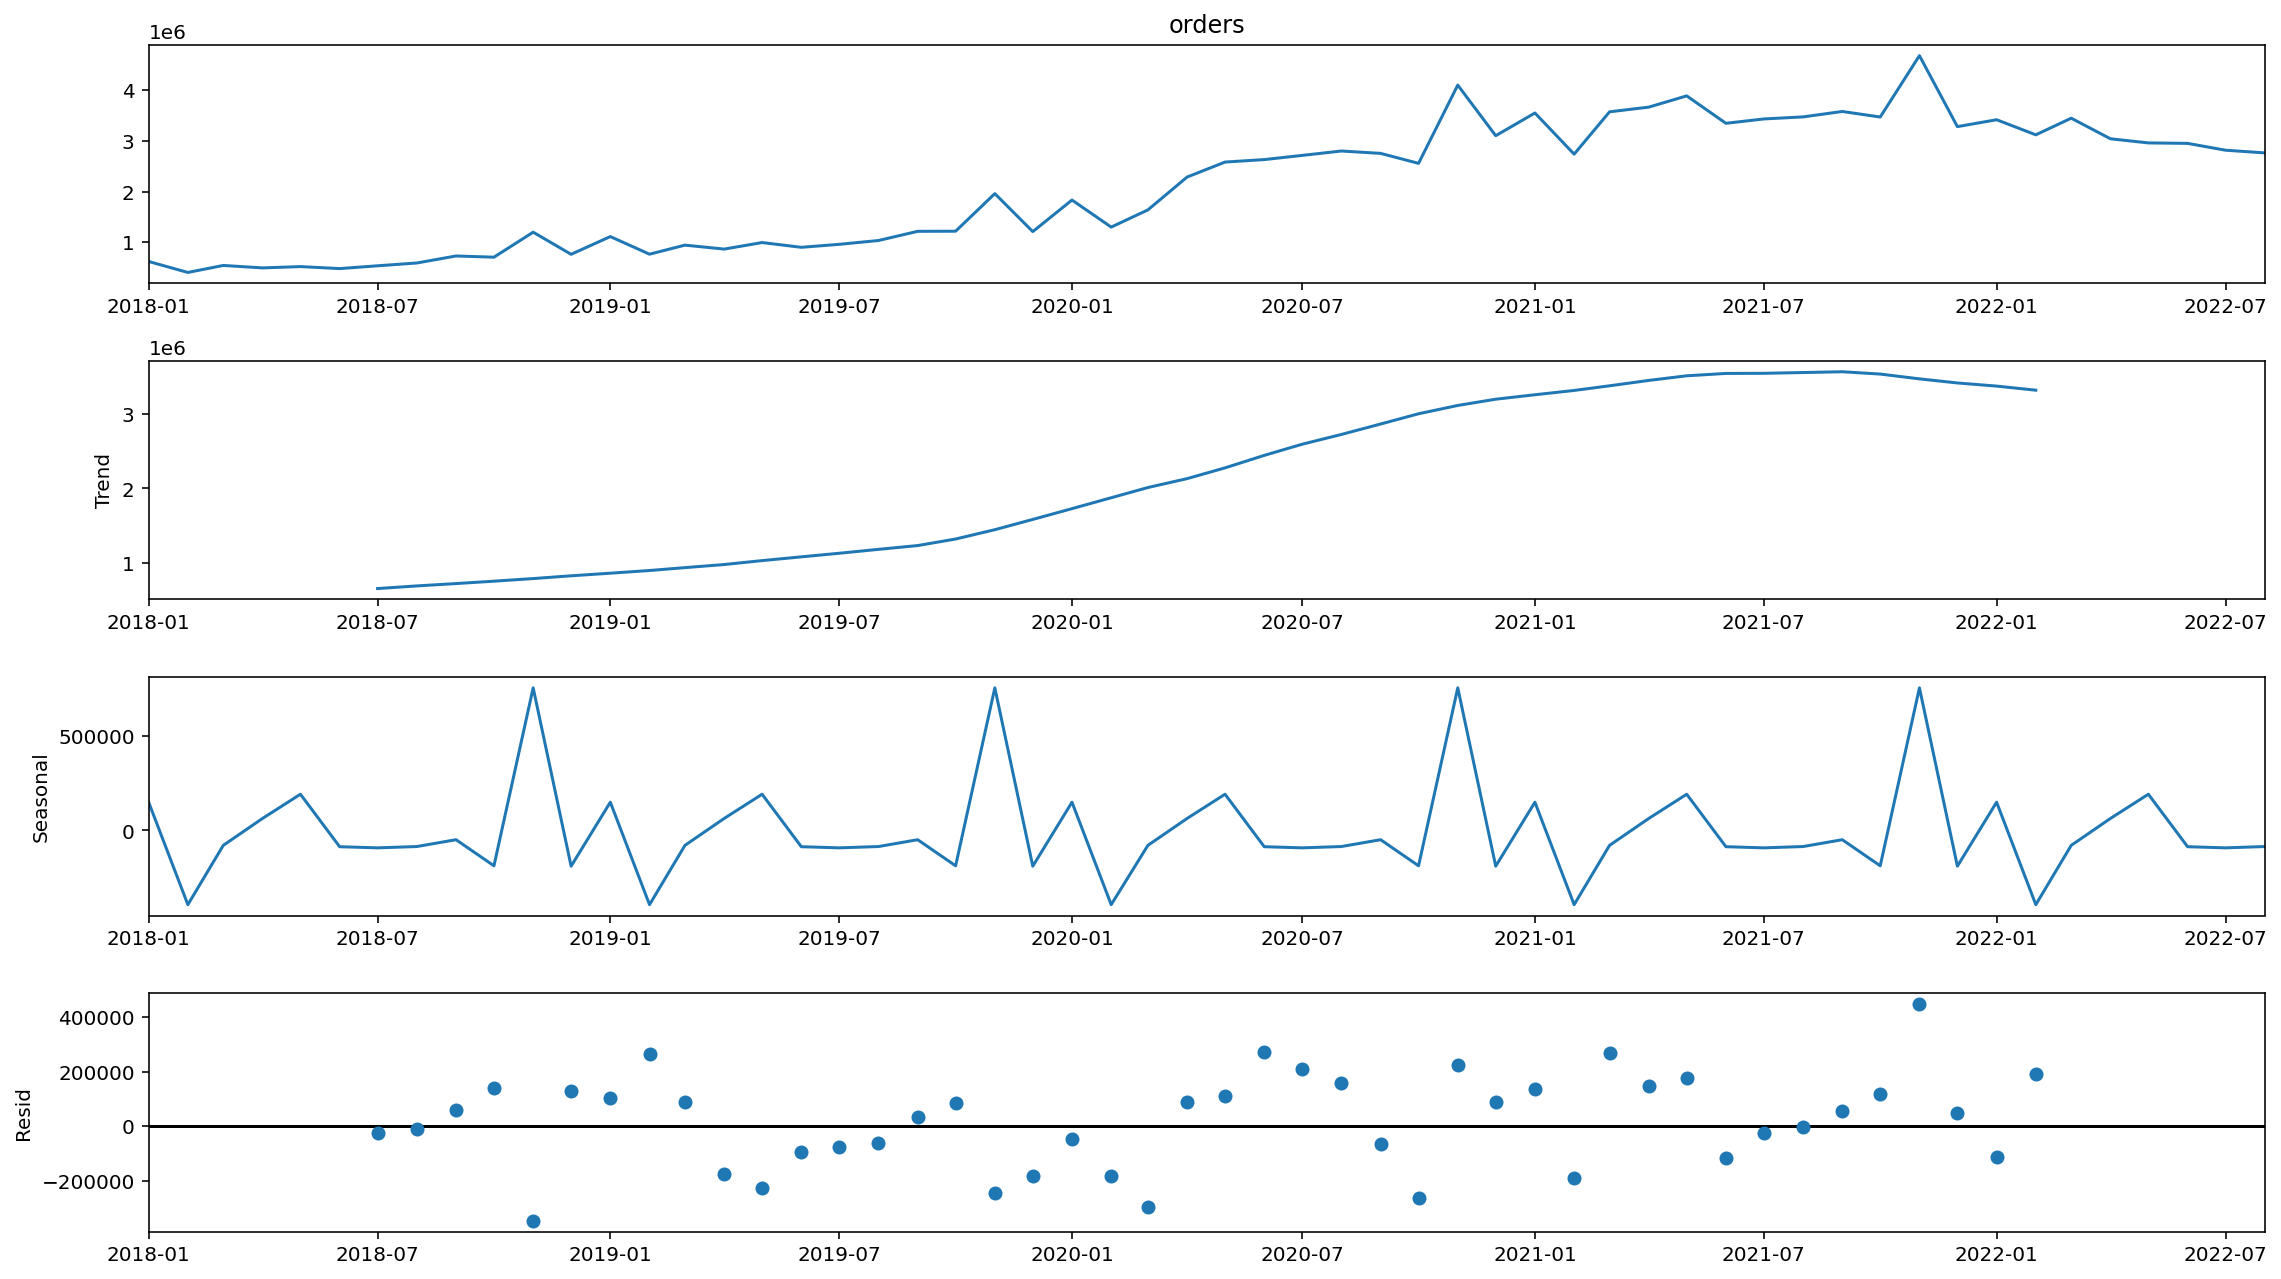

In [30]:
fig = result.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()

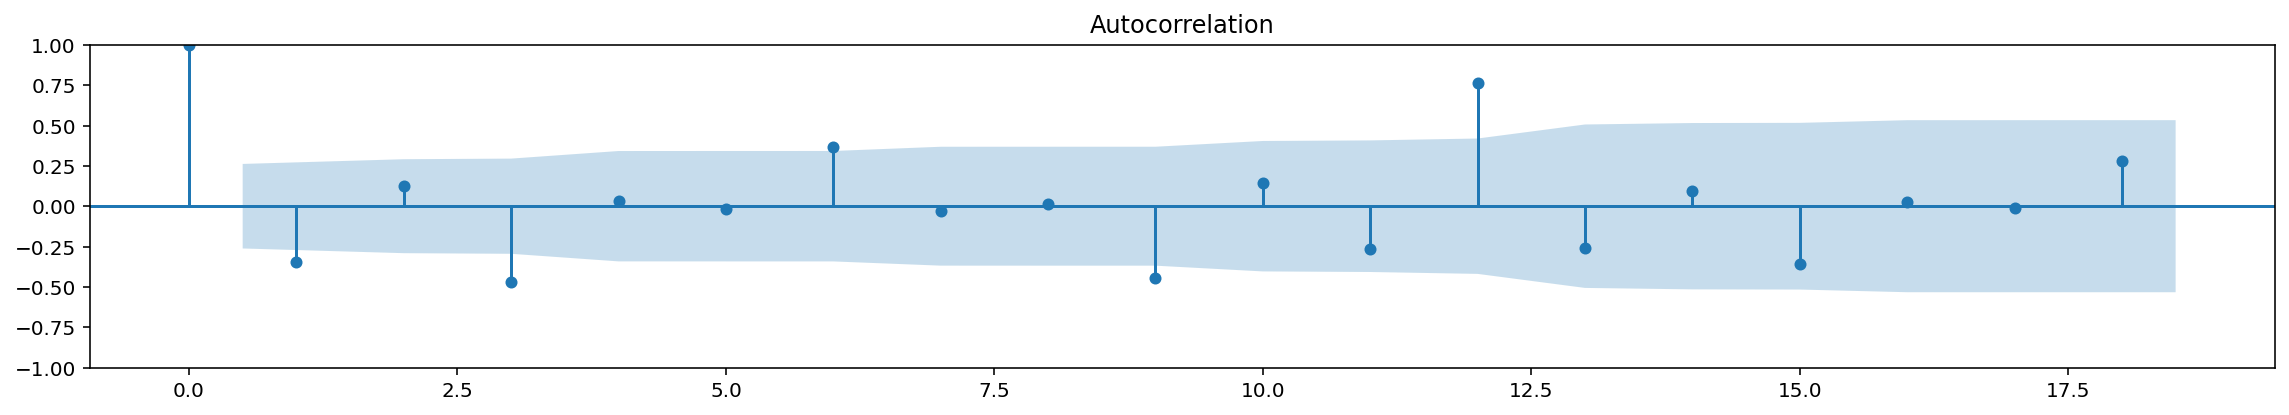

In [31]:
fig = plot_acf(result.seasonal)
fig.set_size_inches((16, 3))
fig.tight_layout()

Easy to notice that the lag[12] high correlation implies in a yearly seazonality

## Original TimeSeries with the differenced one

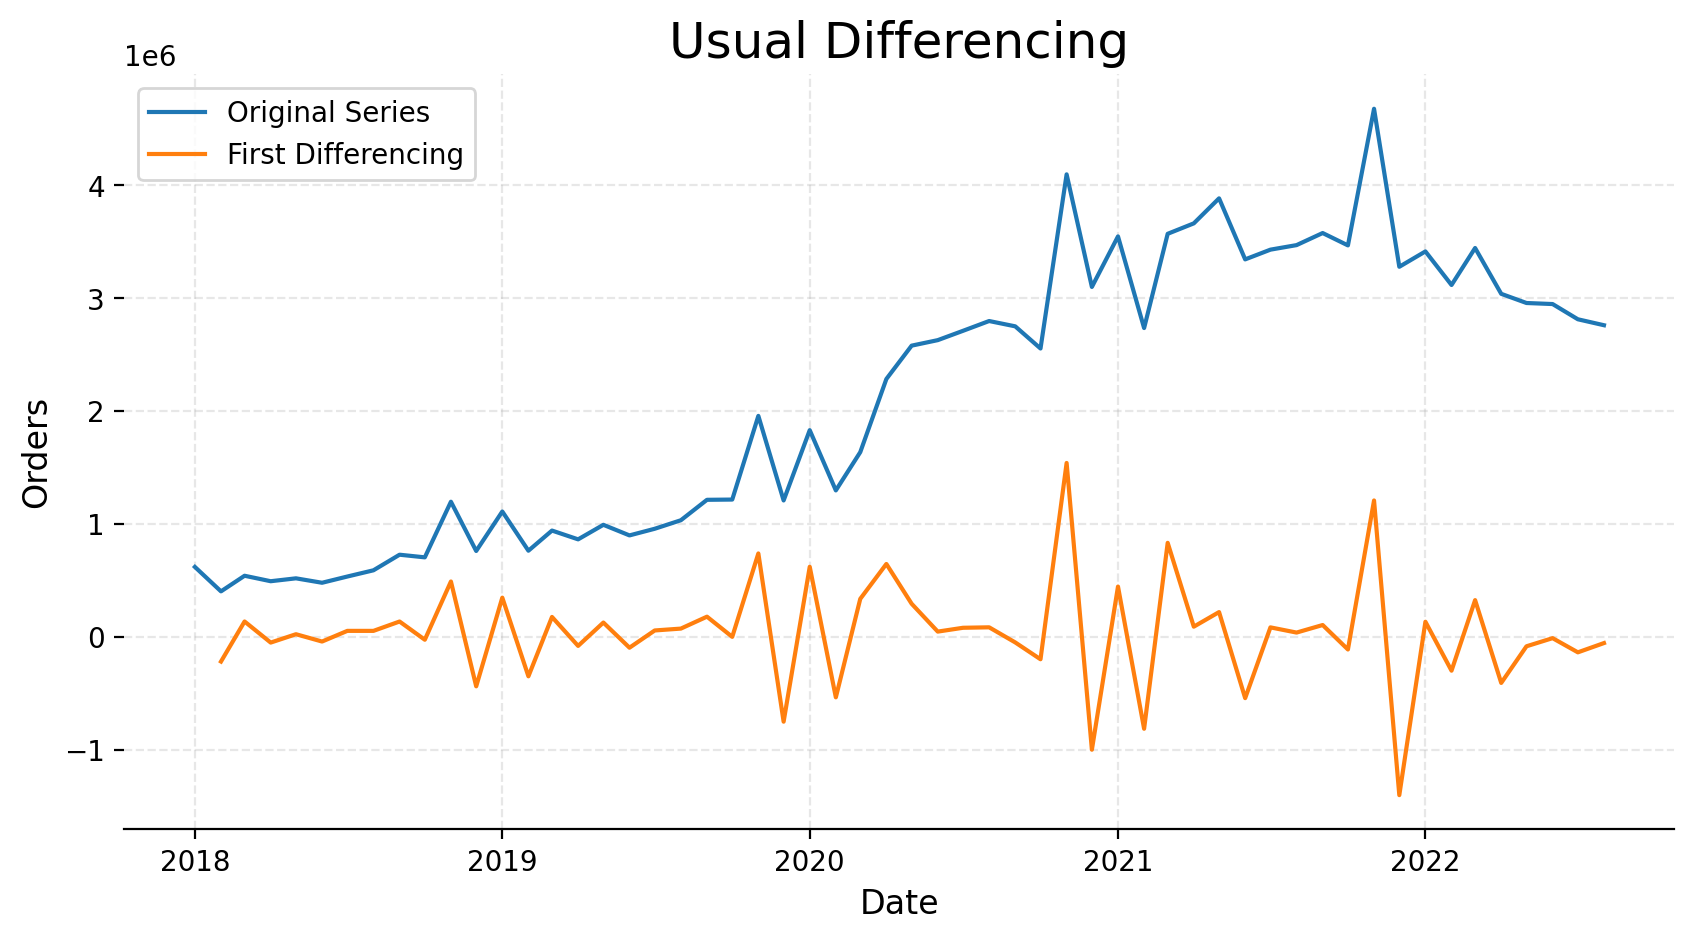

In [32]:
fig, ax = plt.subplots(1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
ax.plot(timeseries, label='Original Series')
ax.plot(timeseries.diff(1), label='First Differencing')
ax.set_title('Usual Differencing', fontsize=18)
ax.legend(loc='upper left', fontsize=10)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Orders", fontsize=12)
ax.grid(linestyle='--', alpha=0.3);

<hr style="height:3px">

# BOX-JENKINS Methodology

In [33]:
def plot_series_acf_pacf(ts, compute_variance=False):

    fig, ax = plt.subplots(nrows=1, figsize=(10,4), dpi=100)

    # Usual Differencing
    ax.plot(ts, label='Series')
    ax.set_title('Series', fontsize=18)
    ax.legend(loc='upper left', fontsize=10)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Orders", fontsize=12)
    ax.grid(linestyle='--', alpha=0.3);

    
    if compute_variance == True:
        variance = list()

        for i in range(len(ts)):
            ts_now = ts[ts.index <= ts.index[i]]
            current_var = np.var(ts_now)
            variance.append(current_var)

        variance_ts = pd.Series(data=variance, index=ts.index)
        ax2 = ax.twinx()
        ax2.plot(variance_ts, 'orange', label='Variance', alpha=0.5)
        
        ax2.legend(loc='upper right', fontsize=10)
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.set_xlabel("Date", fontsize=12)
        ax2.set_ylabel("Orders", fontsize=12)
        plt.fill_between(variance_ts.index, y1=variance_ts, y2=0, alpha=0.15, color='orange')

    
    fig, ax = plt.subplots(ncols=2, figsize=(10,2), dpi=100)
    plot_acf(ts, ax=ax[0])
    plot_pacf(ts, ax=ax[1])

    for i in [0,1]:
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].grid(linestyle='--', alpha=0.3);

    fig.tight_layout()

### 1) First Analysis

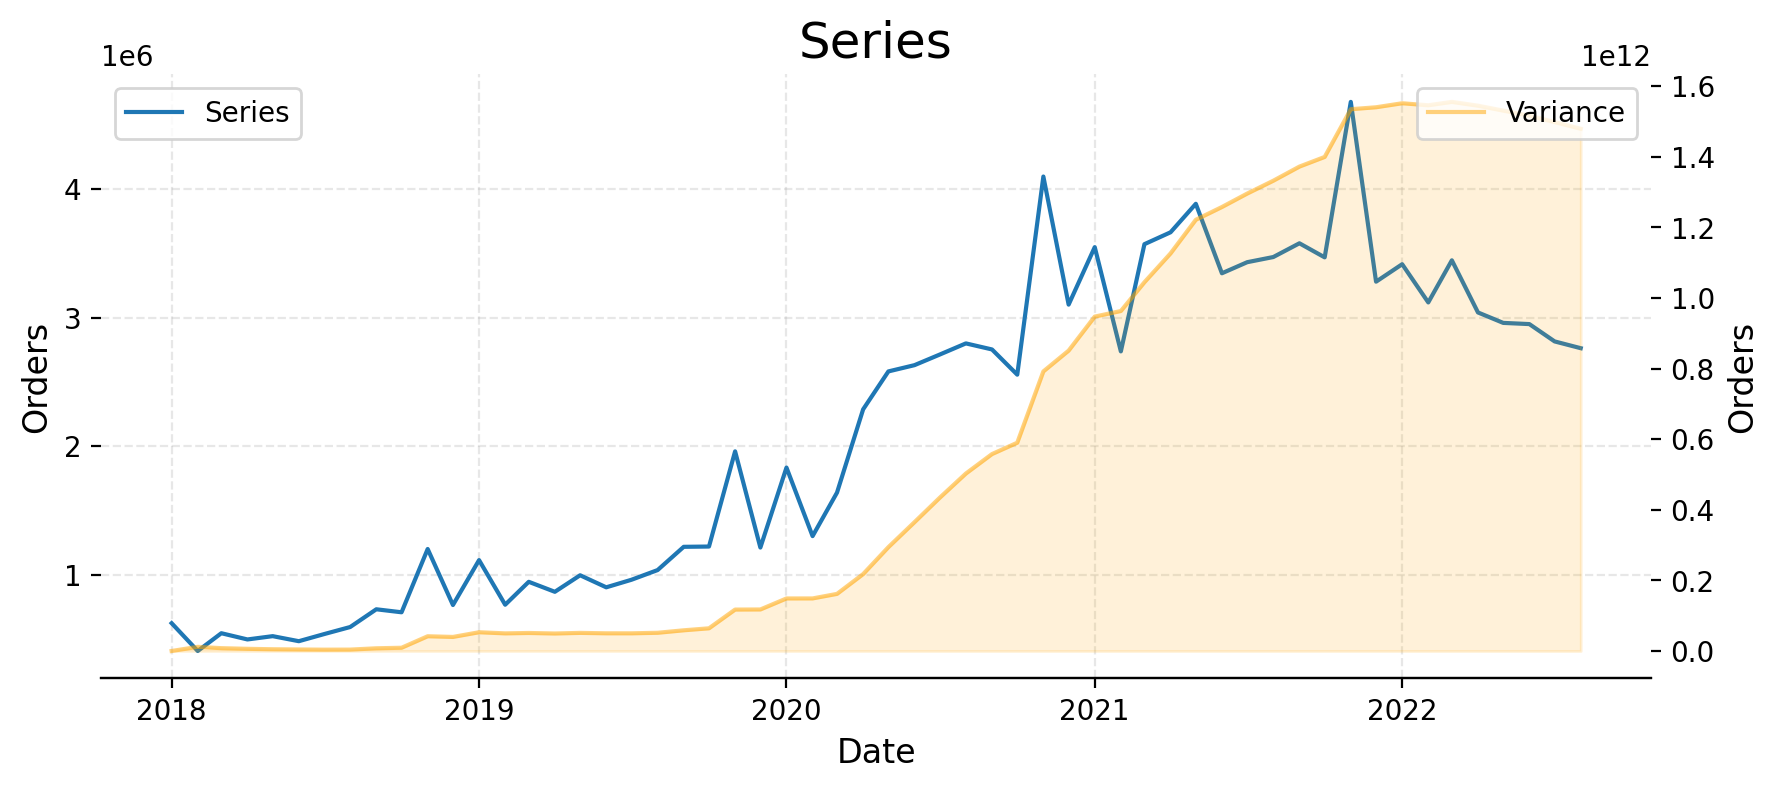

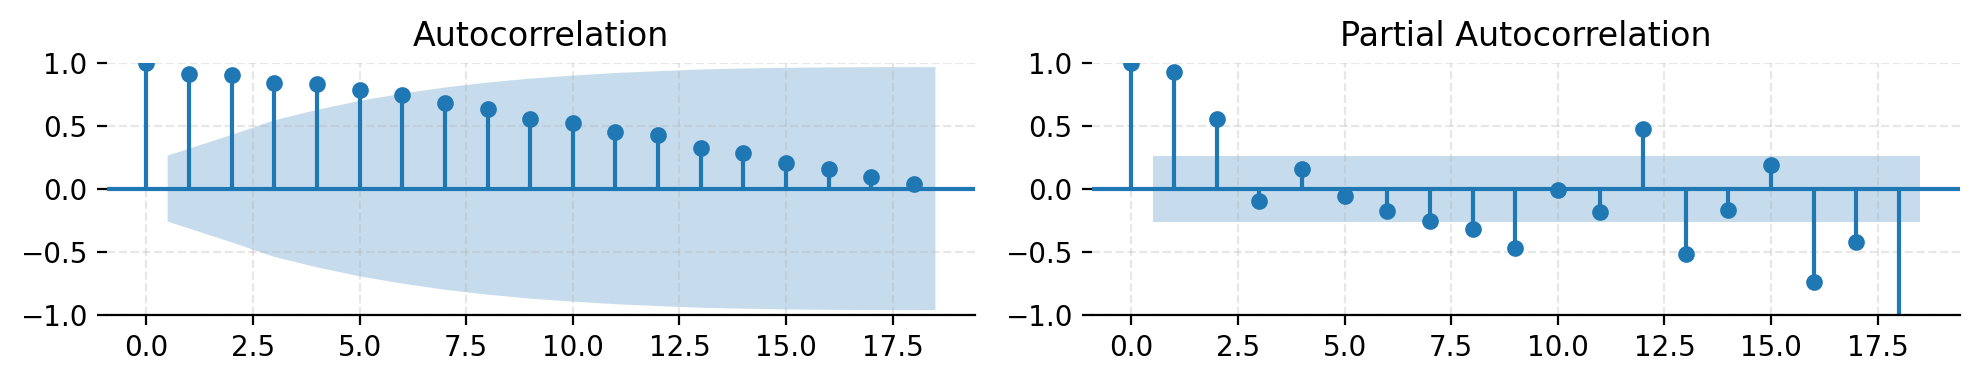

In [34]:
plot_series_acf_pacf(timeseries, compute_variance=True)

#### There's a long correlation with the lags which takes too long to reduce. It implies in a non-stationary series. Let's take the first differences and see the results.

### 2) First Differences

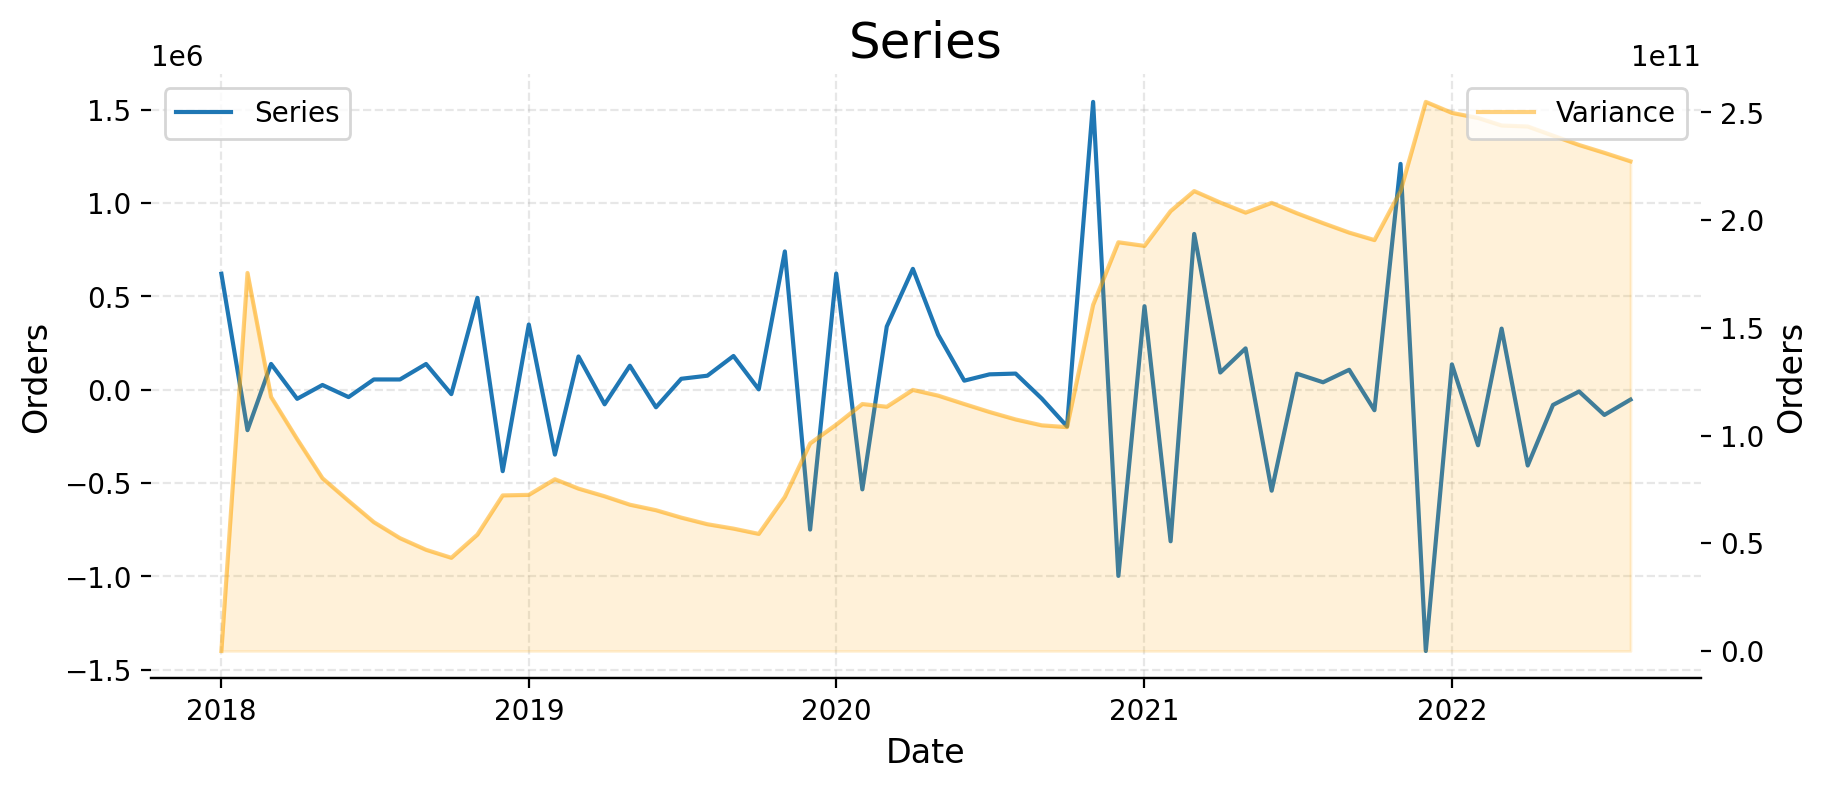

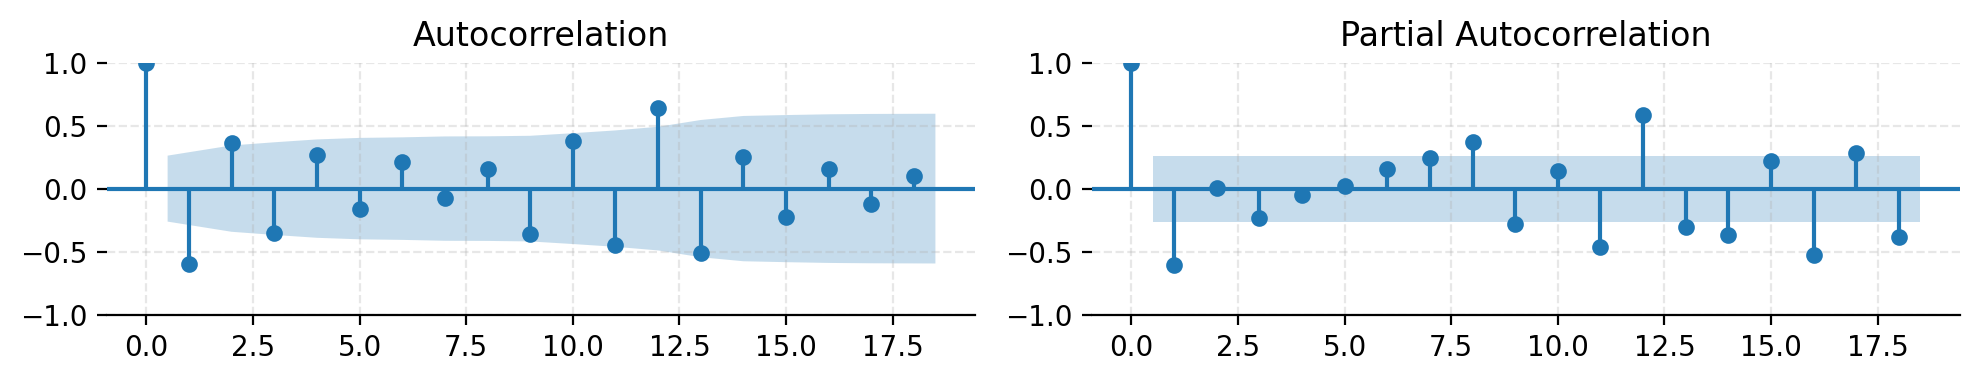

In [49]:
# 1a differences to make it stationary
model = SARIMAX(timeseries,
                order=(0,1,0),
                seasonal_order=(0,0,0,12))

fitted_model = model.fit()
plot_series_acf_pacf(fitted_model.resid, compute_variance=True)

#### The residue isn't a White Noise yet. Let's continue the process.

### 3) Introducing AR(1)

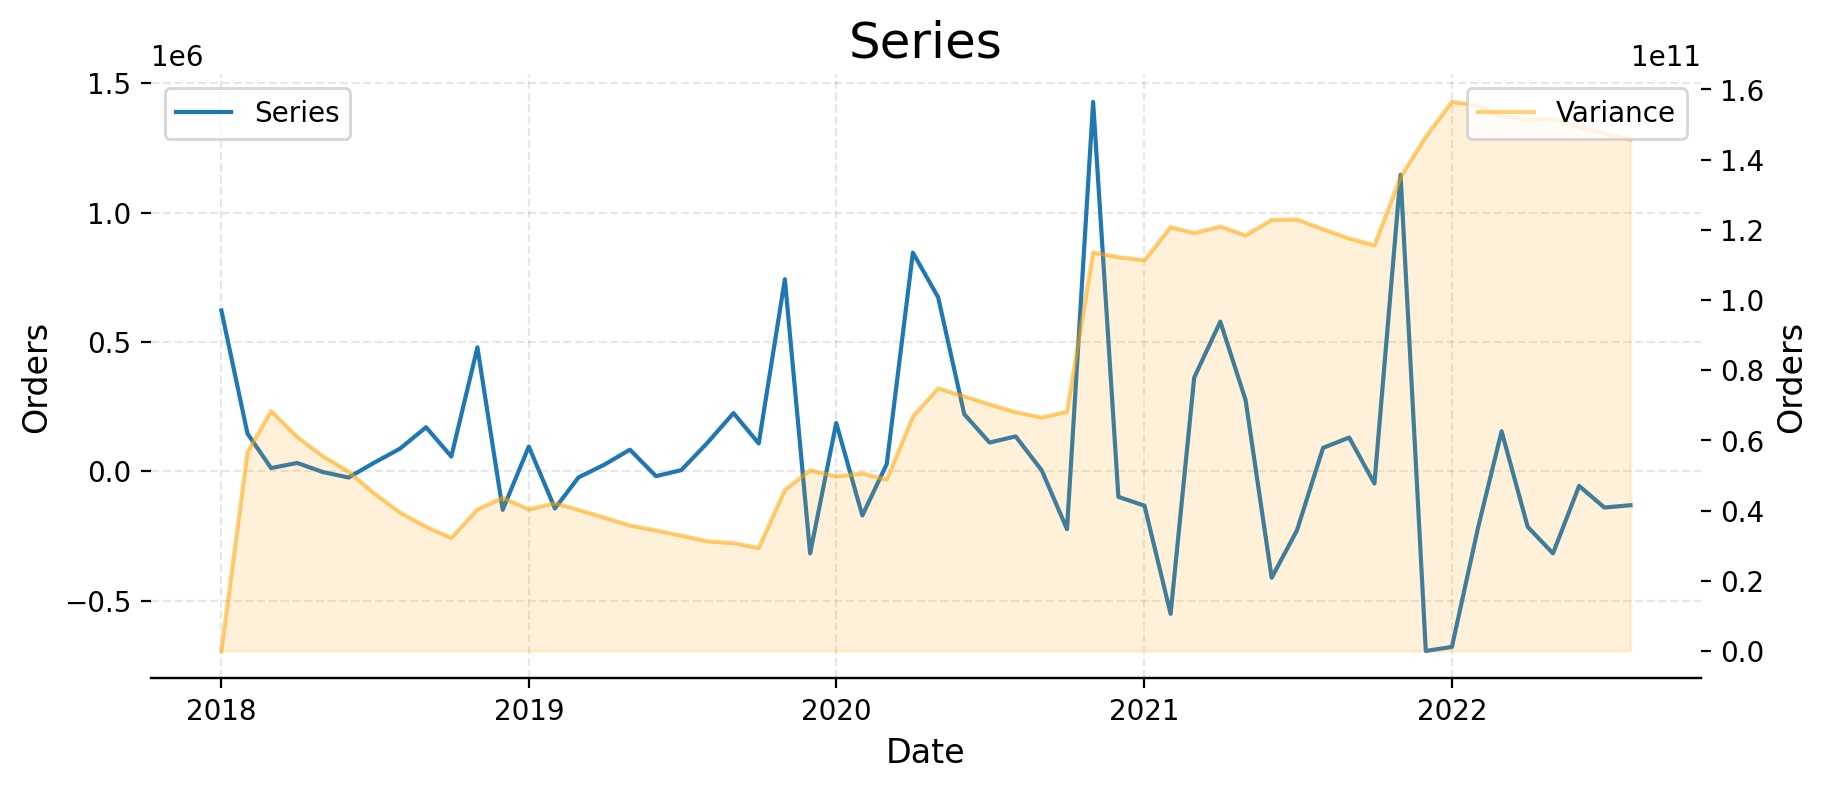

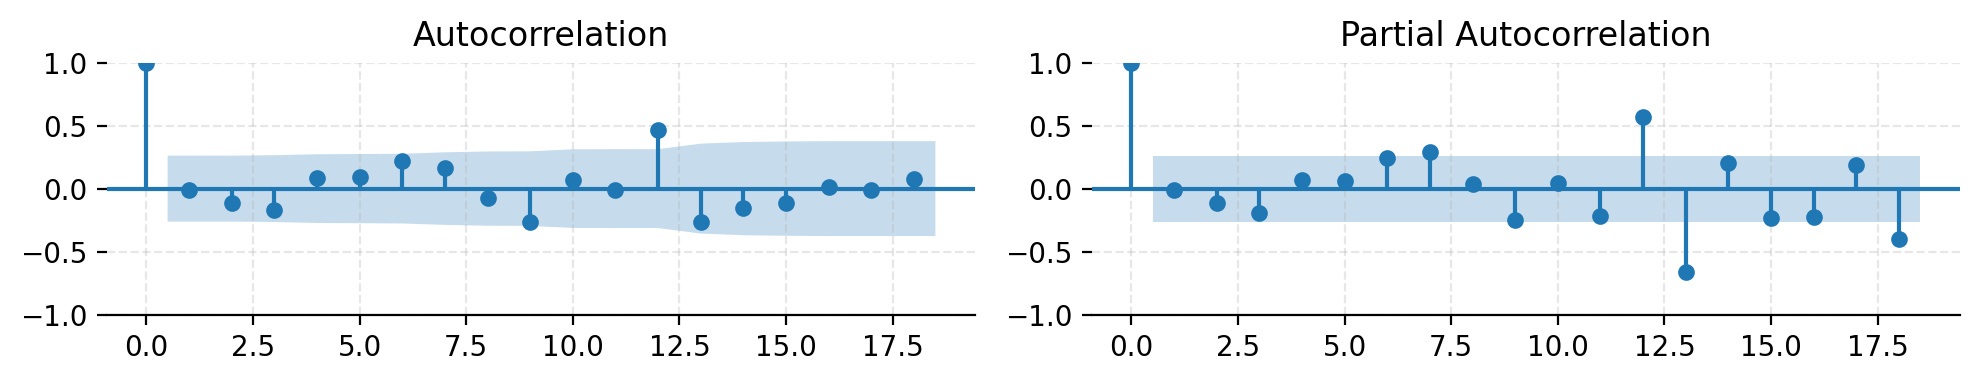

In [50]:
# Adding AR(1)
model = SARIMAX(timeseries,
                order=(1,1,0),
                seasonal_order=(0,0,0,12))

fitted_model = model.fit()
plot_series_acf_pacf(fitted_model.resid, compute_variance=True)

#### We were able to remove the LAG[1] correlation, but there are still some issues

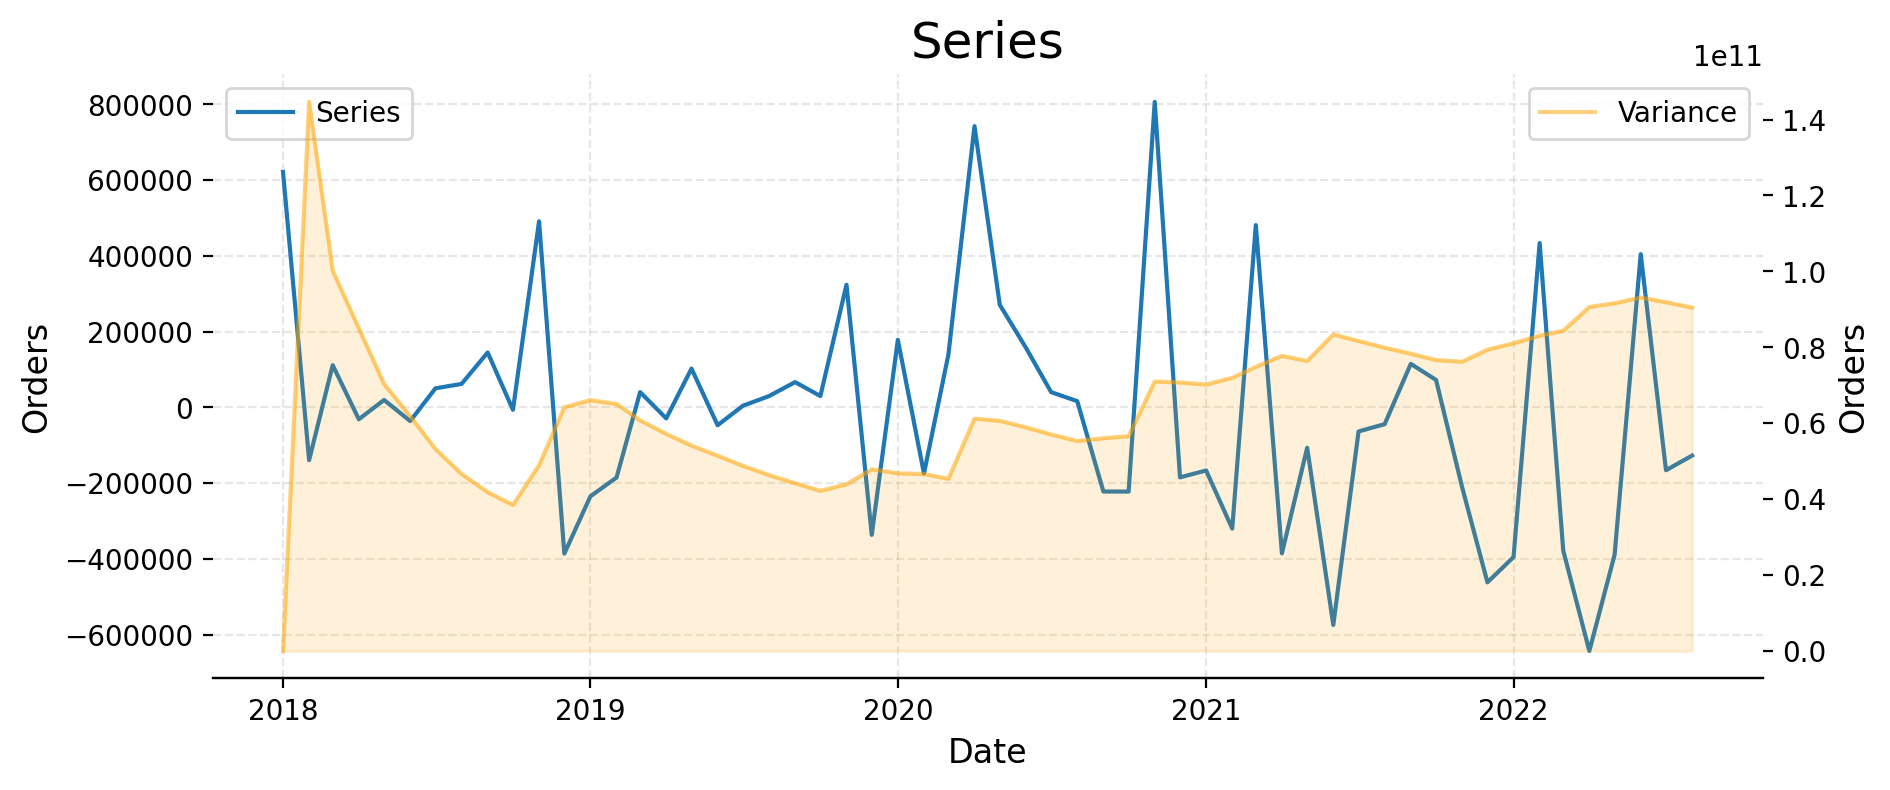

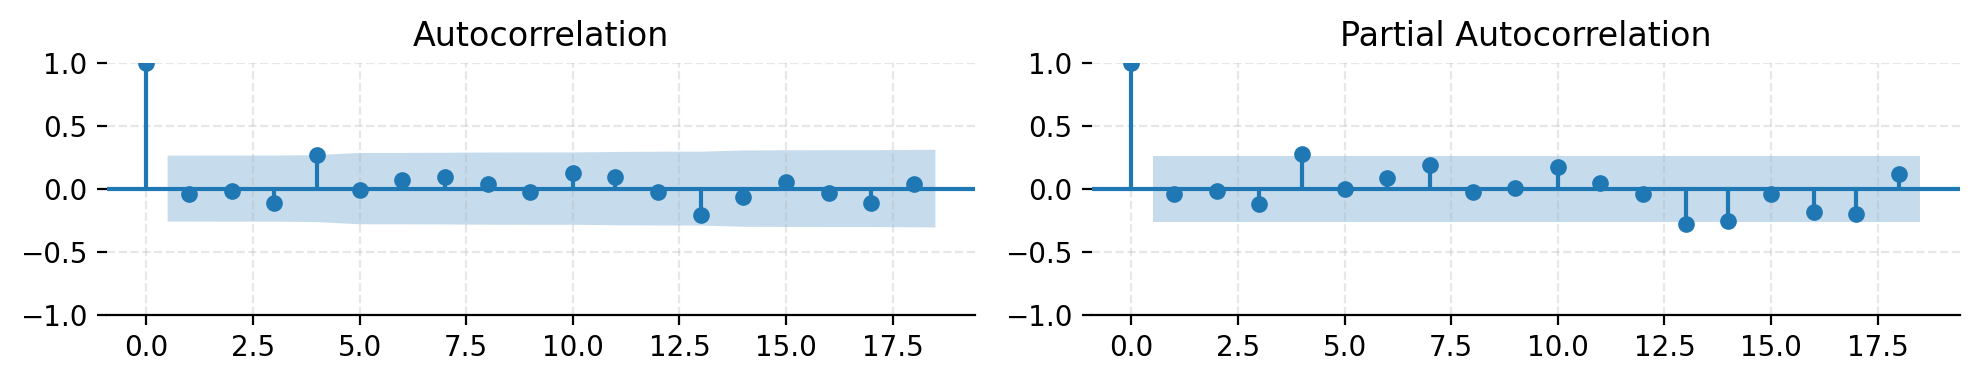

In [51]:
# Adding AR(1)
model = SARIMAX(timeseries,
                order=(1,1,0),
                seasonal_order=(1,1,1,12))

fitted_model = model.fit()
plot_series_acf_pacf(fitted_model.resid, compute_variance=True)

#### Variance is stable along the timeseries period

<hr style="height:3px">

# IMPLEMENTING AUTO SARIMA

In [ ]:
%%time

p_list = [0,1,2,3]
d_list = [0,1,2]
q_list = [0,1,2,3]
P_list = [0,1,2,3]
D_list = [0,1,2]
Q_list = [0,1,2,3]
S_list = [12]

AIC_dict = dict()

# GRID __________________________________________________________
for p in p_list:
    for d in d_list:
        for q in q_list:
            for P in P_list:
                for D in D_list:
                    for Q in Q_list:
                        for S in S_list:
                            my_order = (p, d, q)
                            my_seasonal_order = (P, D, Q, S)
                            
                            # Try it
                            try:
                                # Define model
                                model = SARIMAX(timeseries,
                                                order=my_order,
                                                seasonal_order=my_seasonal_order) 
                                
                                fitted_model = model.fit()
                                
                                # Gets the residual sum
                                RMSE = np.sqrt(fitted_model.mse) #(timeseries - fitted_model.forecasts[0])
                                
                                # Results
                                AIC_dict[my_order + my_seasonal_order] = fitted_model.aic, RMSE
                            
                            # In case that something goes wrong...
                            except:
                                AIC_dict[my_order + my_seasonal_order] = np.nan

In [ ]:
df_results = pd.DataFrame.from_dict(AIC_dict, orient='index').reset_index().rename(columns={'index':'params',0:'AIC',1:'RMSE'})

In [ ]:
df_results.sort_values('RMSE').head(5)

In [ ]:
df_results.to_csv("results/df_results3.csv", sep=';')

## Using the best parameters

In [53]:
# parameters = ((2, 1, 2), (1, 3, 1, 12))
parameters = ((3, 1, 3), (1, 0, 0, 12))

In [54]:
my_order = parameters[0]
my_seasonal_order = parameters[1]

In [55]:
model = SARIMAX(timeseries,
                order=my_order,
                seasonal_order=my_seasonal_order) 

In [56]:
fitted_model = model.fit()

In [59]:
fitted_model.aic

1563.970273486455

# PREDICTING NEW VALUES

Each observation in a time series can be **forecast** using all previous observations. We call these fitted values and they are denoted by:

$\hat{y}_{t}|_{t-1} $

https://otexts.com/fpp2/residuals.html

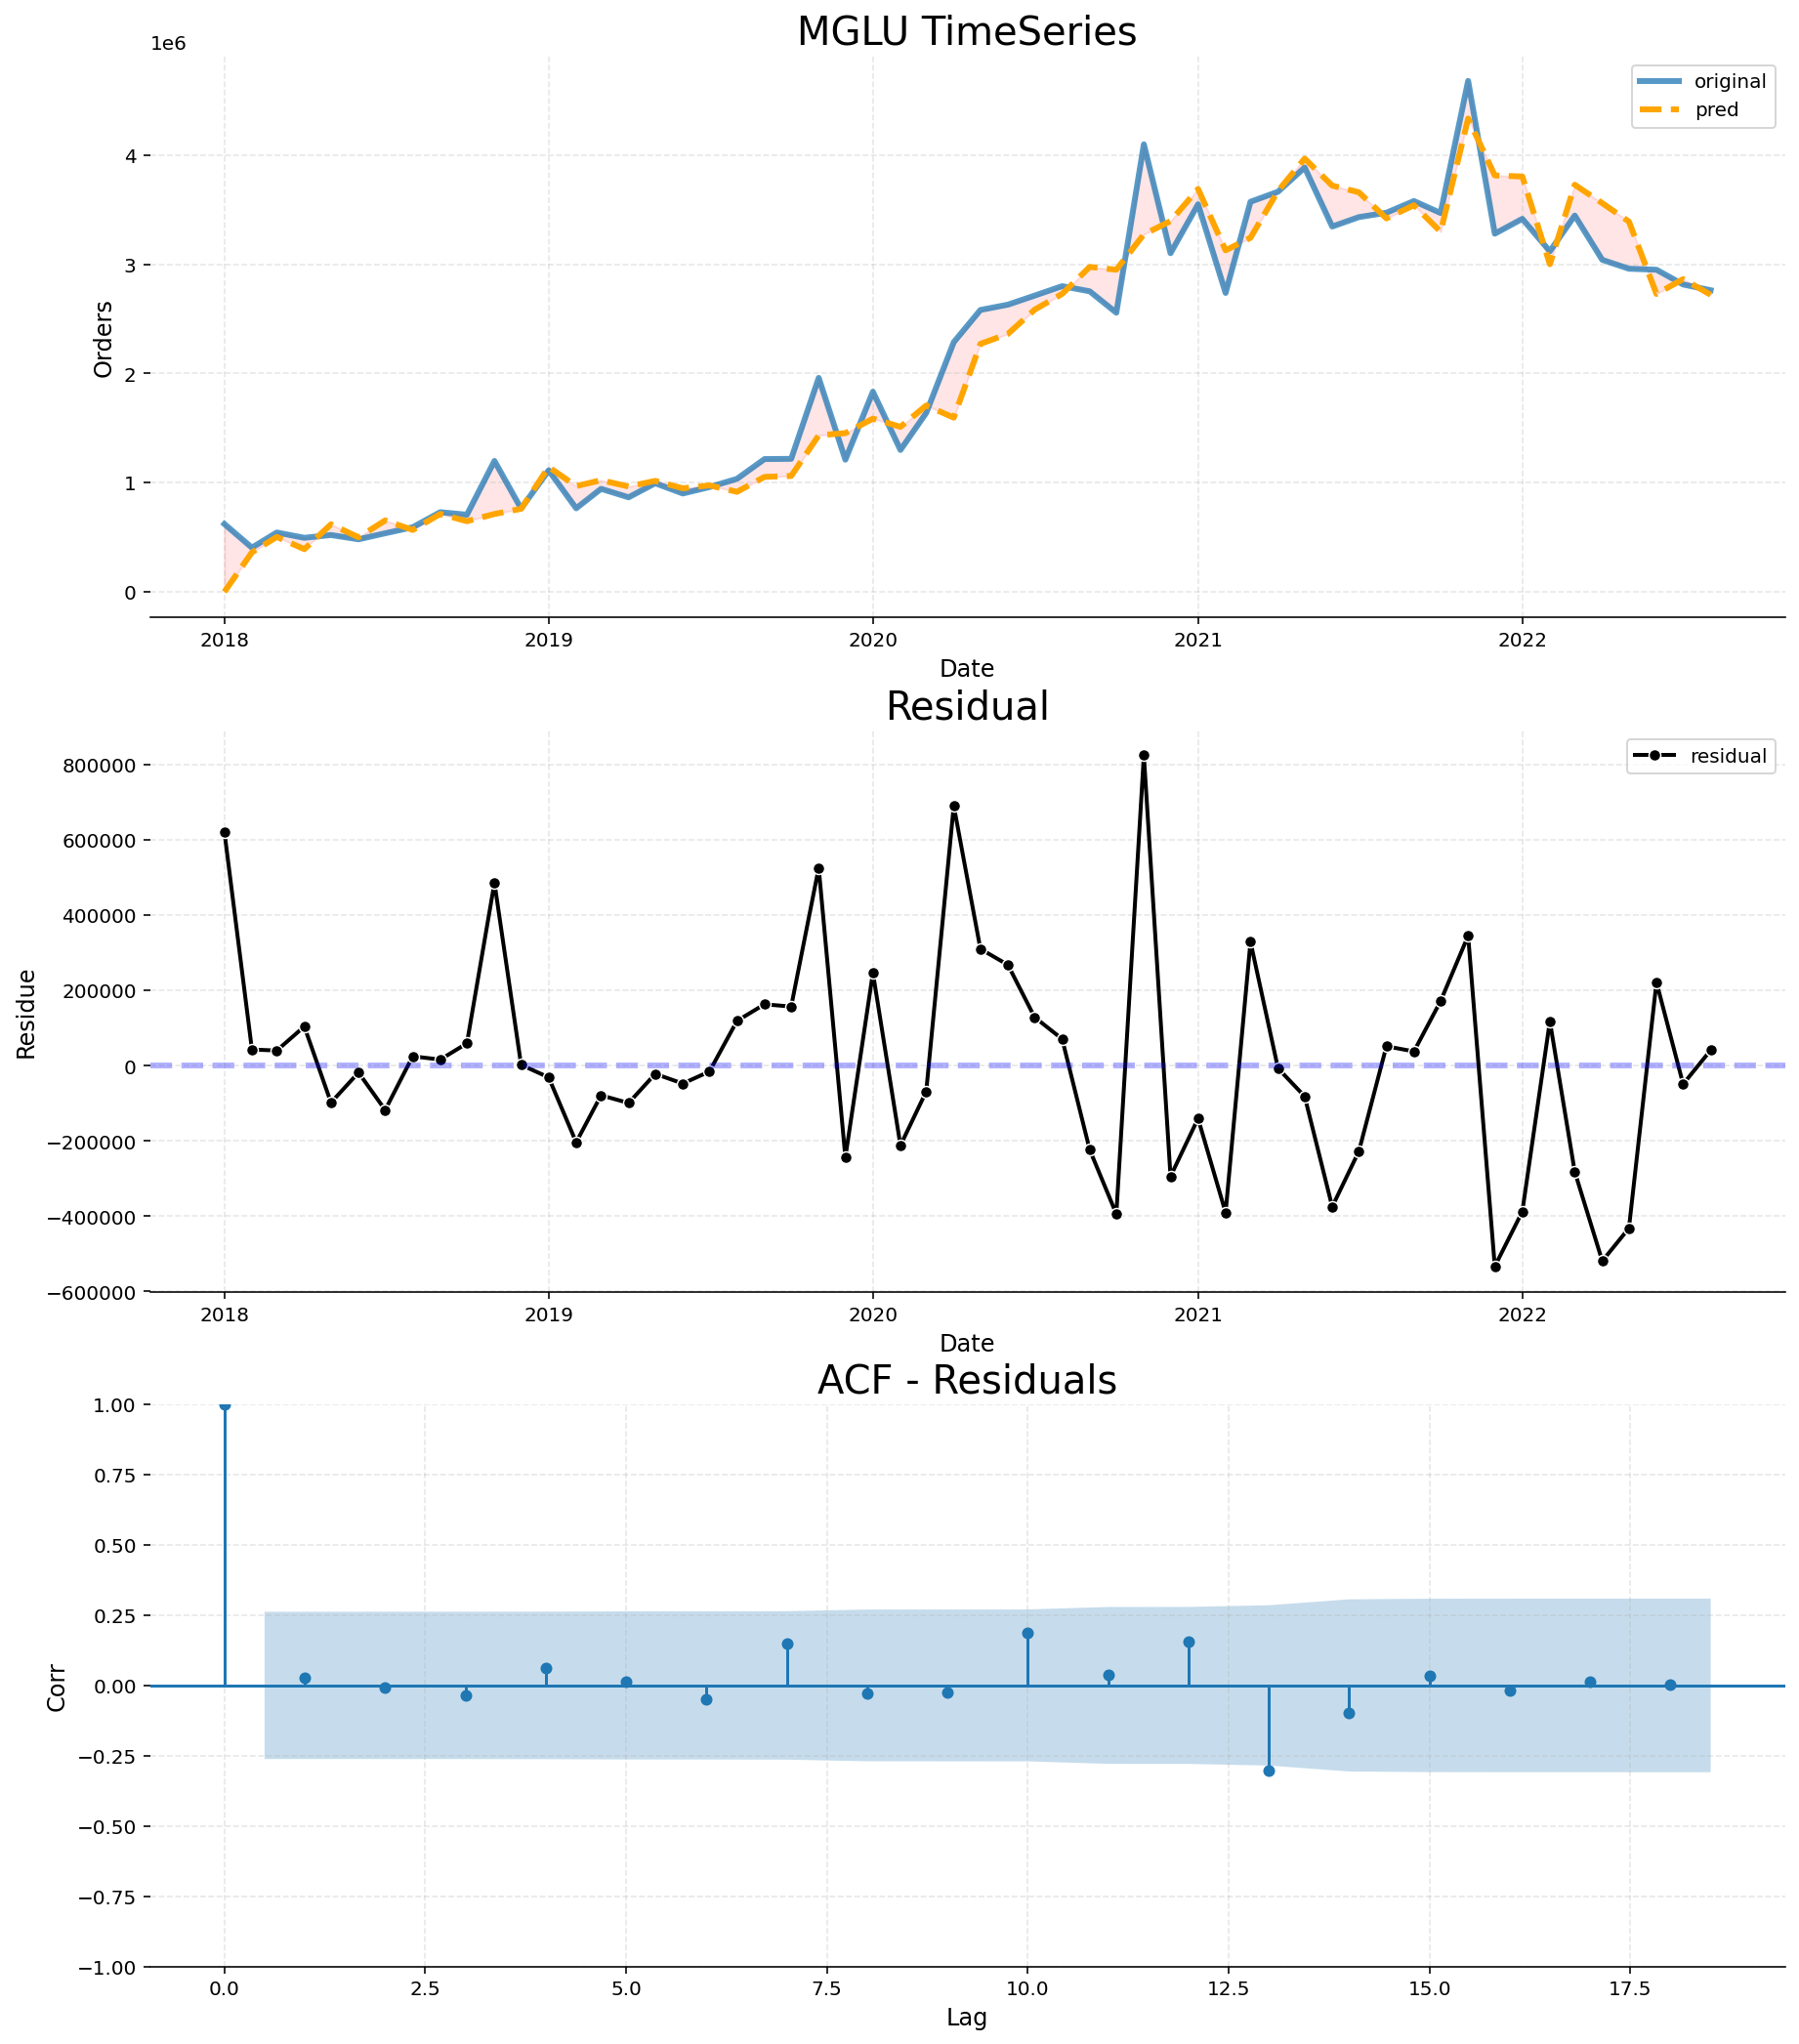

In [60]:
fig, ax = plt.subplots(nrows=3, figsize = (15,18))

fit = sm.tsa.STL(timeseries).fit()

original_ts = timeseries.copy()
predicted_ts_sarima = fitted_model.predict()
residuals = fitted_model.resid


# Axis 1_________________________
sns.lineplot(data=original_ts, label='original', ax=ax[0], linestyle='-', alpha=.75, linewidth=3);
sns.lineplot(data=predicted_ts_sarima, label="pred", ax=ax[0], linestyle='--', color='orange', linewidth=3);
ax[0].fill_between(timeseries.index, original_ts, predicted_ts_sarima, alpha=0.1, color='red')
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xlabel("Date", fontsize=12)
ax[0].set_ylabel("Orders", fontsize=12)
ax[0].grid(linestyle='--', alpha=0.3);
ax[0].set_title("MGLU TimeSeries", fontsize=20)


# Axis 2_________________________
sns.lineplot(data=residuals, label="residual", ax=ax[1], linestyle='-', color='black', marker='o', linewidth=2);
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['top'].set_visible(False)

ax[1].axhline(y=0, color='blue', linestyle='--', alpha=0.3, linewidth=3)
ax[1].set_xlabel("Date", fontsize=12)
ax[1].set_ylabel("Residue", fontsize=12)
ax[1].grid(linestyle='--', alpha=0.3);
ax[1].set_title("Residual", fontsize=20);


plot_acf(residuals, ax[2])
ax[2].spines['right'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].set_xlabel("Lag", fontsize=12)
ax[2].set_ylabel("Corr", fontsize=12)
ax[2].grid(linestyle='--', alpha=0.3);
ax[2].set_title("ACF - Residuals", fontsize=20);

# Train & Test Split

### Predicting the Test Split

In [61]:
from datetime import datetime, timedelta

In [62]:
parameters = ((3, 1, 3), (1, 0, 0, 12))
PERIODS_TO_PREDICT = 4

my_order = parameters[0]
my_seasonal_order = parameters[1]

train = timeseries[:-PERIODS_TO_PREDICT]
test = timeseries[-PERIODS_TO_PREDICT:]

# Generating the Model
model = SARIMAX(train,
                order=my_order,
                seasonal_order=my_seasonal_order) 

# Fitting
fitted_model = model.fit()

In [63]:
fitted_model.aic

1451.3869359151624

In [64]:
np.sqrt(fitted_model.mse)

284632.42533563636

In [65]:
test

date
2022-05-01    2958682
2022-06-01    2949433
2022-07-01    2814559
2022-08-01    2761819
Name: orders, dtype: int64

In [69]:
# Prediction
START_PREDICTION = test.index[0] #train.index[-1]
END_PREDICTION = test.index[-1] #pd.date_range(START_PREDICTION, periods=PERIODS_TO_PREDICT, freq='MS')[-1]

prediction = fitted_model.predict(start=START_PREDICTION,end=END_PREDICTION,dynamic=True)

df_final = timeseries.reset_index()
df_prediction = prediction.reset_index().rename(columns={'index':'date'})
df_final = df_final.merge(df_prediction, how='left', on='date')


# Just to connect the last original point to the first prediction point 
index_to_change = df_final[df_final['date'] == (START_PREDICTION-relativedelta(months=1))].index[0]
value = df_final.loc[index_to_change]['orders']
df_final.loc[index_to_change,'predicted_mean'] = value

In [70]:
np.sqrt(((df_final.tail(5)['orders'] - df_final.tail(5)['predicted_mean'])**2).mean())

262521.79321460496

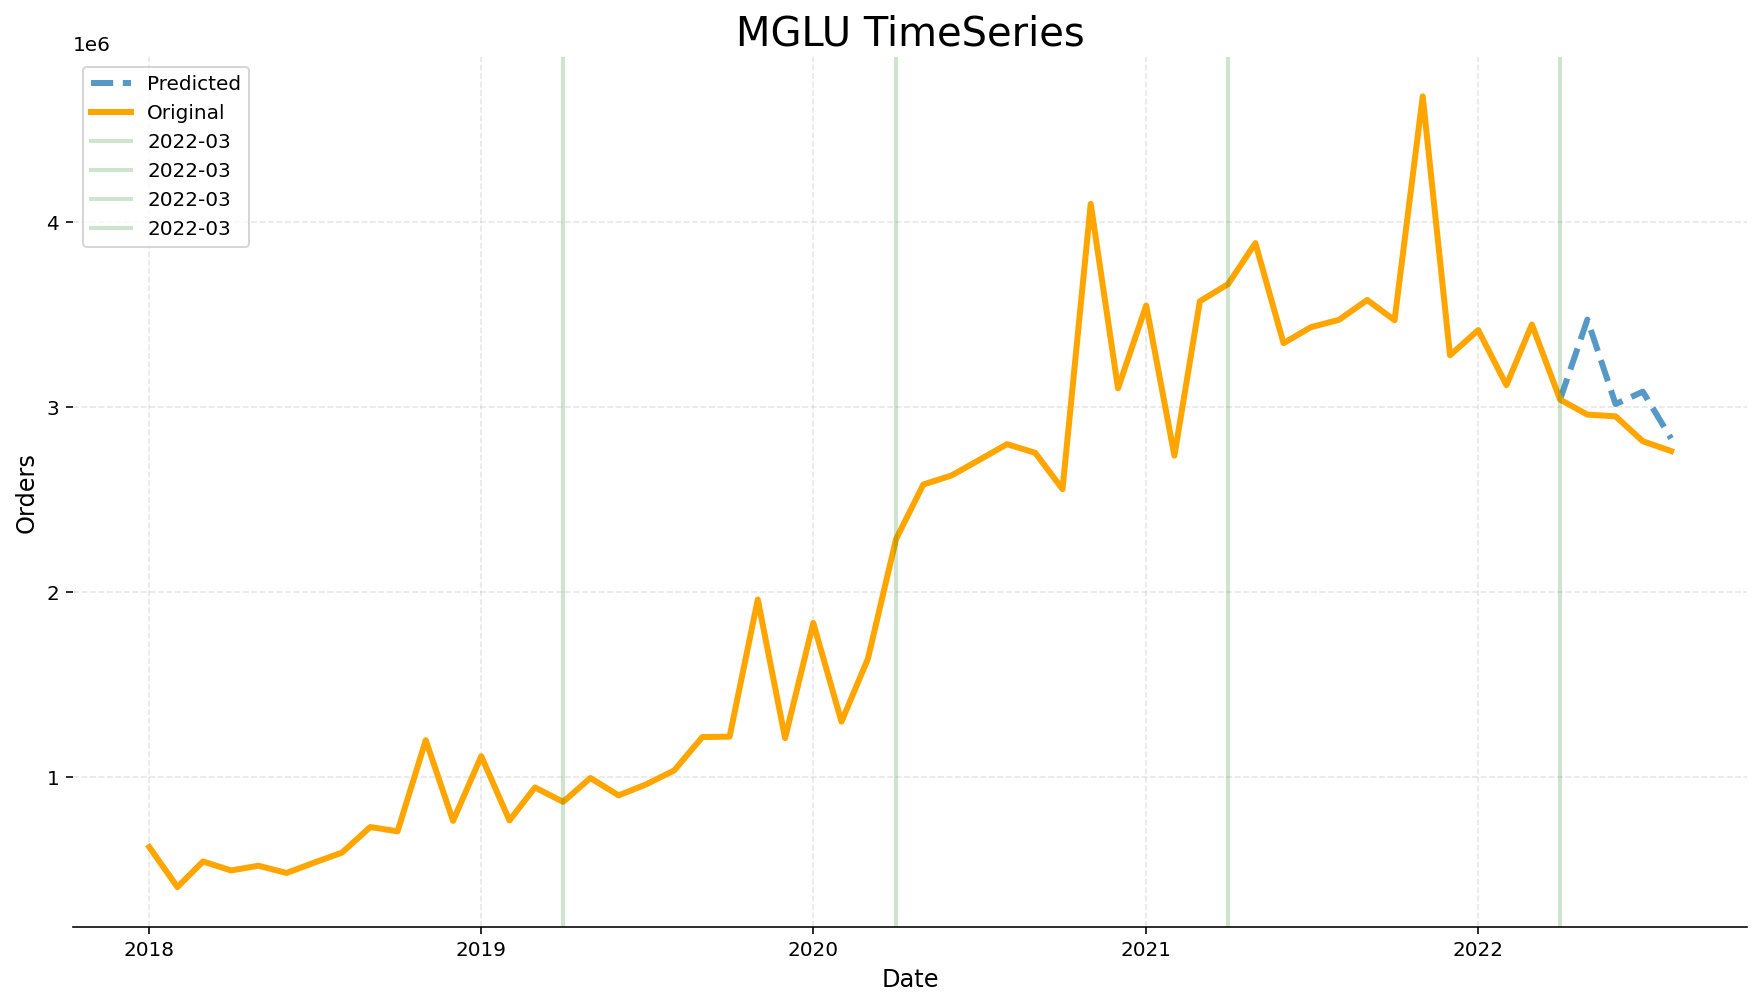

In [71]:
fig, ax = plt.subplots(ncols=1, figsize = (15,8))

original_ts = train.copy()
predicted_ts = prediction
residuals = fitted_model.resid

plt.title("MGLU TimeSeries", fontsize=20)
sns.lineplot(data=df_final, x='date', y='predicted_mean',label='Predicted', ax=ax, linestyle='--', alpha=.75, linewidth=3);
sns.lineplot(data=df_final, x='date', y='orders',label="Original", ax=ax, linestyle='-', color='orange', linewidth=3);

ax.axvline(x=datetime(year=2022, month=4, day=1), color='green', linestyle='-', alpha=0.2, linewidth=2, label='2022-03')
ax.axvline(x=datetime(year=2021, month=4, day=1), color='green', linestyle='-', alpha=0.2, linewidth=2, label='2022-03')
ax.axvline(x=datetime(year=2020, month=4, day=1), color='green', linestyle='-', alpha=0.2, linewidth=2, label='2022-03')
ax.axvline(x=datetime(year=2019, month=4, day=1), color='green', linestyle='-', alpha=0.2, linewidth=2, label='2022-03')
ax.legend(loc='upper left', fontsize=10)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Orders", fontsize=12)
ax.grid(linestyle='--', alpha=0.3);

# Predicting +5 steps

In [72]:
# Prediction Range
PERIODS_TO_PREDICT = 4
START_PREDICTION = datetime(year=2022, month=9, day=1)
END_PREDICTION = START_PREDICTION + relativedelta(months=PERIODS_TO_PREDICT)

In [73]:
# Predicting
prediction = fitted_model.predict(start=START_PREDICTION,
                                  end=END_PREDICTION,
                                  dynamic=True)

# Create prediction DataFrame
df_prediction = prediction.reset_index().rename(columns={'index':'date'})

In [74]:
# Creating main DF and concating everything
df_final = timeseries.reset_index()
df_final = pd.concat([df_final, df_prediction], axis=0).reset_index(drop=True)

In [75]:
# Just to connect the last original point to the first prediction point 
index_to_change = df_final[df_final['date'] == START_PREDICTION-relativedelta(months=1)].index[0]
value = df_final.loc[index_to_change]['orders']
df_final.loc[index_to_change,'predicted_mean'] = value

In [76]:
df_final.tail(6)

date     orders  predicted_mean
55 2022-08-01  2761819.0    2.761819e+06
56 2022-09-01        NaN    2.899896e+06
57 2022-10-01        NaN    2.624959e+06
58 2022-11-01        NaN    3.420141e+06
59 2022-12-01        NaN    2.483033e+06
60 2023-01-01        NaN    2.713798e+06

In [77]:
s = START_PREDICTION - relativedelta(months=12)
e = END_PREDICTION - relativedelta(months=12)

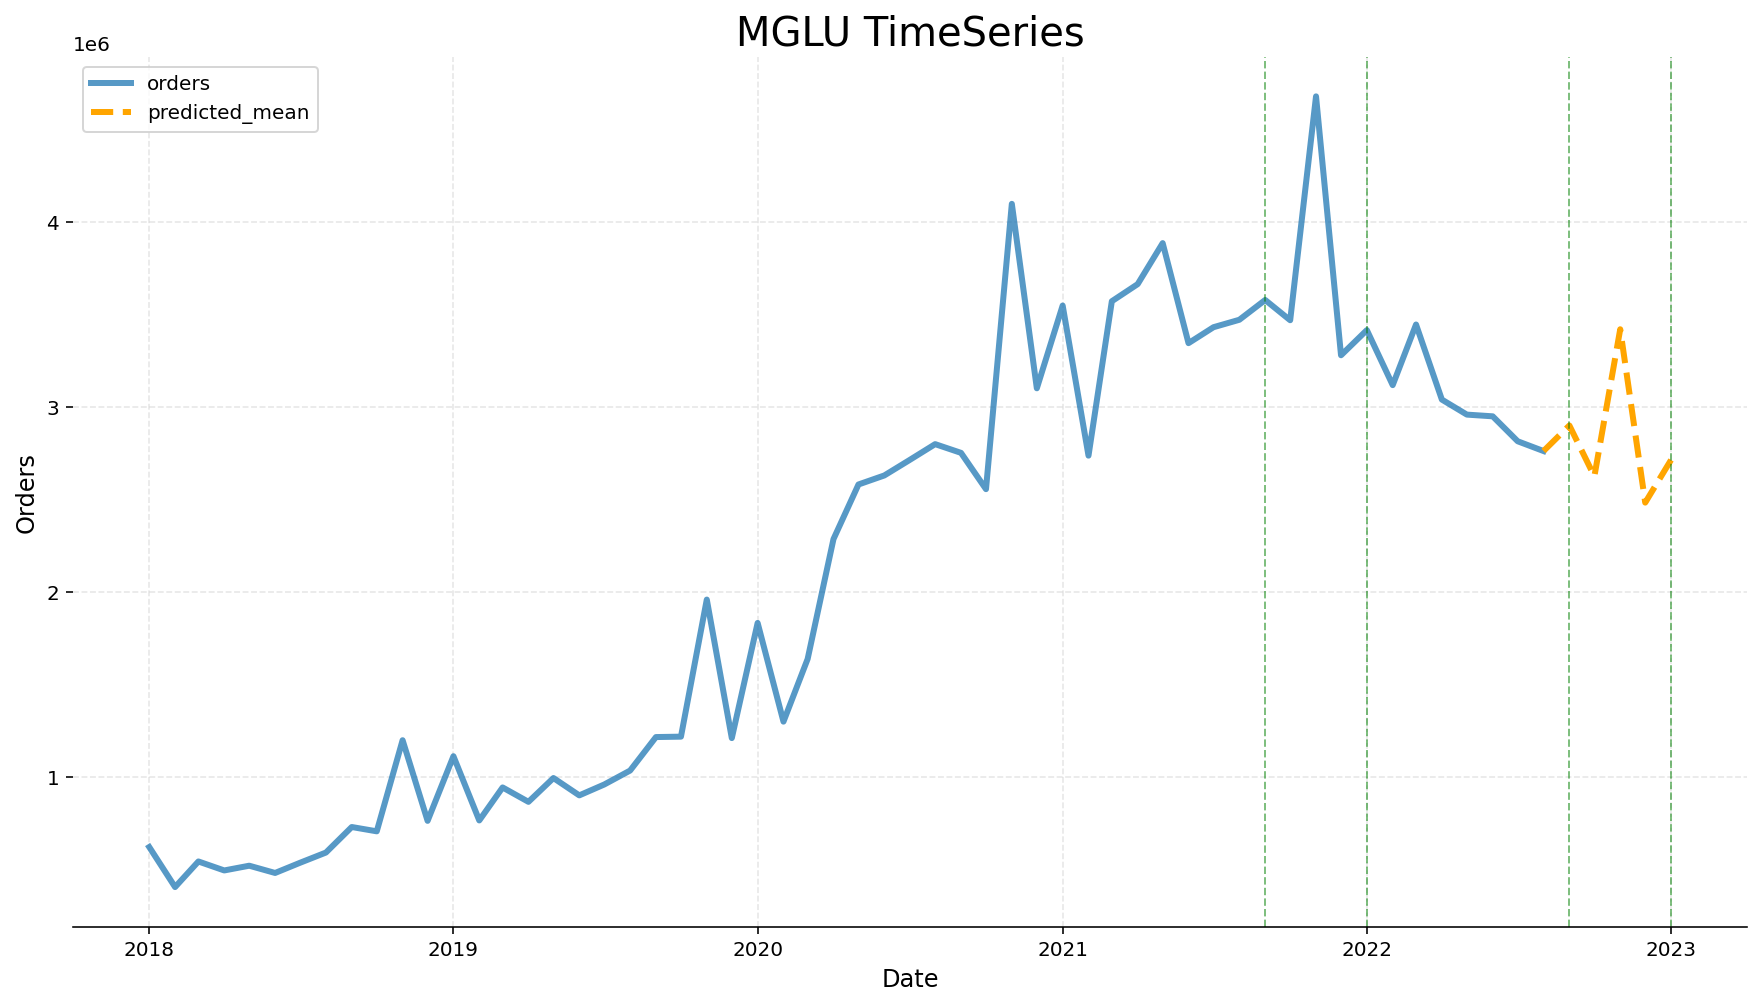

In [78]:
fig, ax = plt.subplots(ncols=1, figsize = (15,8))


plt.title("MGLU TimeSeries", fontsize=20)
sns.lineplot(data=df_final, x='date', y='orders', label='orders', ax=ax, linestyle='-', alpha=.75, linewidth=3);
sns.lineplot(data=df_final, x='date', y='predicted_mean', label="predicted_mean", ax=ax, linestyle='--', color='orange', linewidth=3);


ax.axvline(x=s, color='green', linestyle='--', alpha=0.5, linewidth=1)
ax.axvline(x=e, color='green', linestyle='--', alpha=0.5, linewidth=1)

ax.axvline(x=START_PREDICTION, color='green', linestyle='--', alpha=0.5, linewidth=1)
ax.axvline(x=END_PREDICTION, color='green', linestyle='--', alpha=0.5, linewidth=1)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Orders", fontsize=12)
ax.grid(linestyle='--', alpha=0.3);

# PROPHET

In [79]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

In [80]:
#aqui eu crio uma coluna com o feriado Black Friday pro prophet entender que Novembro é um mês atípico
black_friday = pd.DataFrame({'holiday': 'Black Friday',
                             'ds': pd.to_datetime(
                                 ['2018-11-01',
                                  '2019-11-01',
                                  '2020-11-01',
                                  '2021-11-01',
                                  '2022-11-01'])})

black_friday

holiday         ds
0  Black Friday 2018-11-01
1  Black Friday 2019-11-01
2  Black Friday 2020-11-01
3  Black Friday 2021-11-01
4  Black Friday 2022-11-01

In [81]:
df = timeseries.reset_index().rename(columns={'date':'ds', 'orders':'y'})

18:47:27 - cmdstanpy - INFO - Chain [1] start processing
18:47:28 - cmdstanpy - INFO - Chain [1] done processing


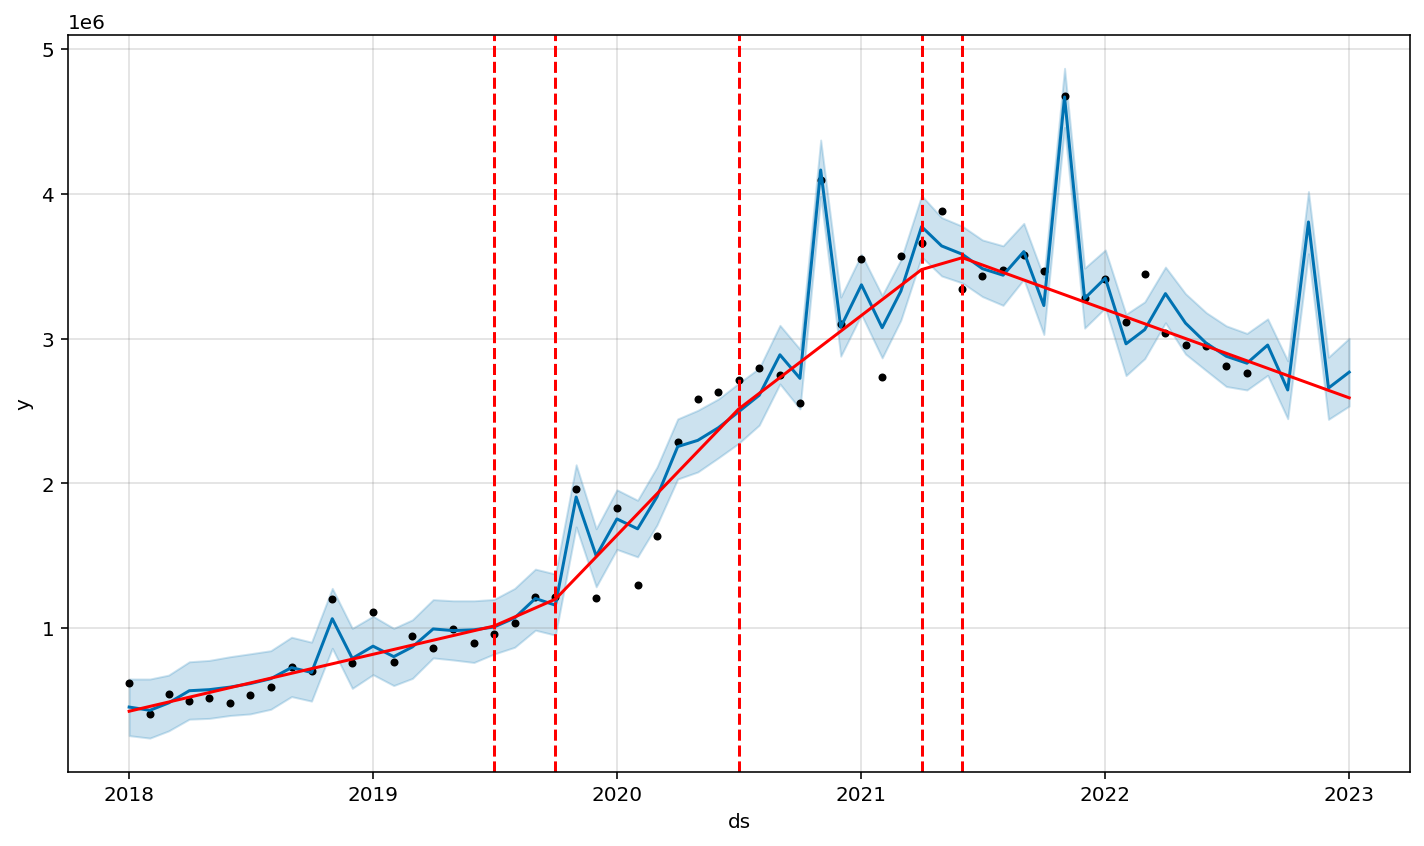

In [82]:
#monto o modelo Prophet
model = Prophet(seasonality_mode='multiplicative',
                changepoint_range=0.75,
                changepoint_prior_scale=0.25,
                yearly_seasonality=4,
                n_changepoints=25,
                holidays=black_friday)

model.fit(df)

future = model.make_future_dataframe(periods=5, freq='MS')

forecast = model.predict(future)

fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show(fig)

## Buiding full dataframe

In [83]:
df_full = df_final.rename(columns={'date':'ds'}).merge(forecast[['ds','yhat','yhat_lower','yhat_upper']], on='ds', how='inner')

In [84]:
df_full = df_full.rename(columns={'predicted_mean':'sarima_future_predictions'})

In [85]:
df_full = df_full.merge(predicted_ts_sarima.reset_index().rename(columns={'index':'ds','predicted_mean':'yhat_sarima'}), on='ds', how='left').rename(columns={'yhat':'yhat_prophet'})

In [86]:
df_full['type'] = np.where(df_full['ds'] > datetime(year=2022, month=8, day=1), 'future', 'has_original_data')

# Prediction Sarima vs Prophet

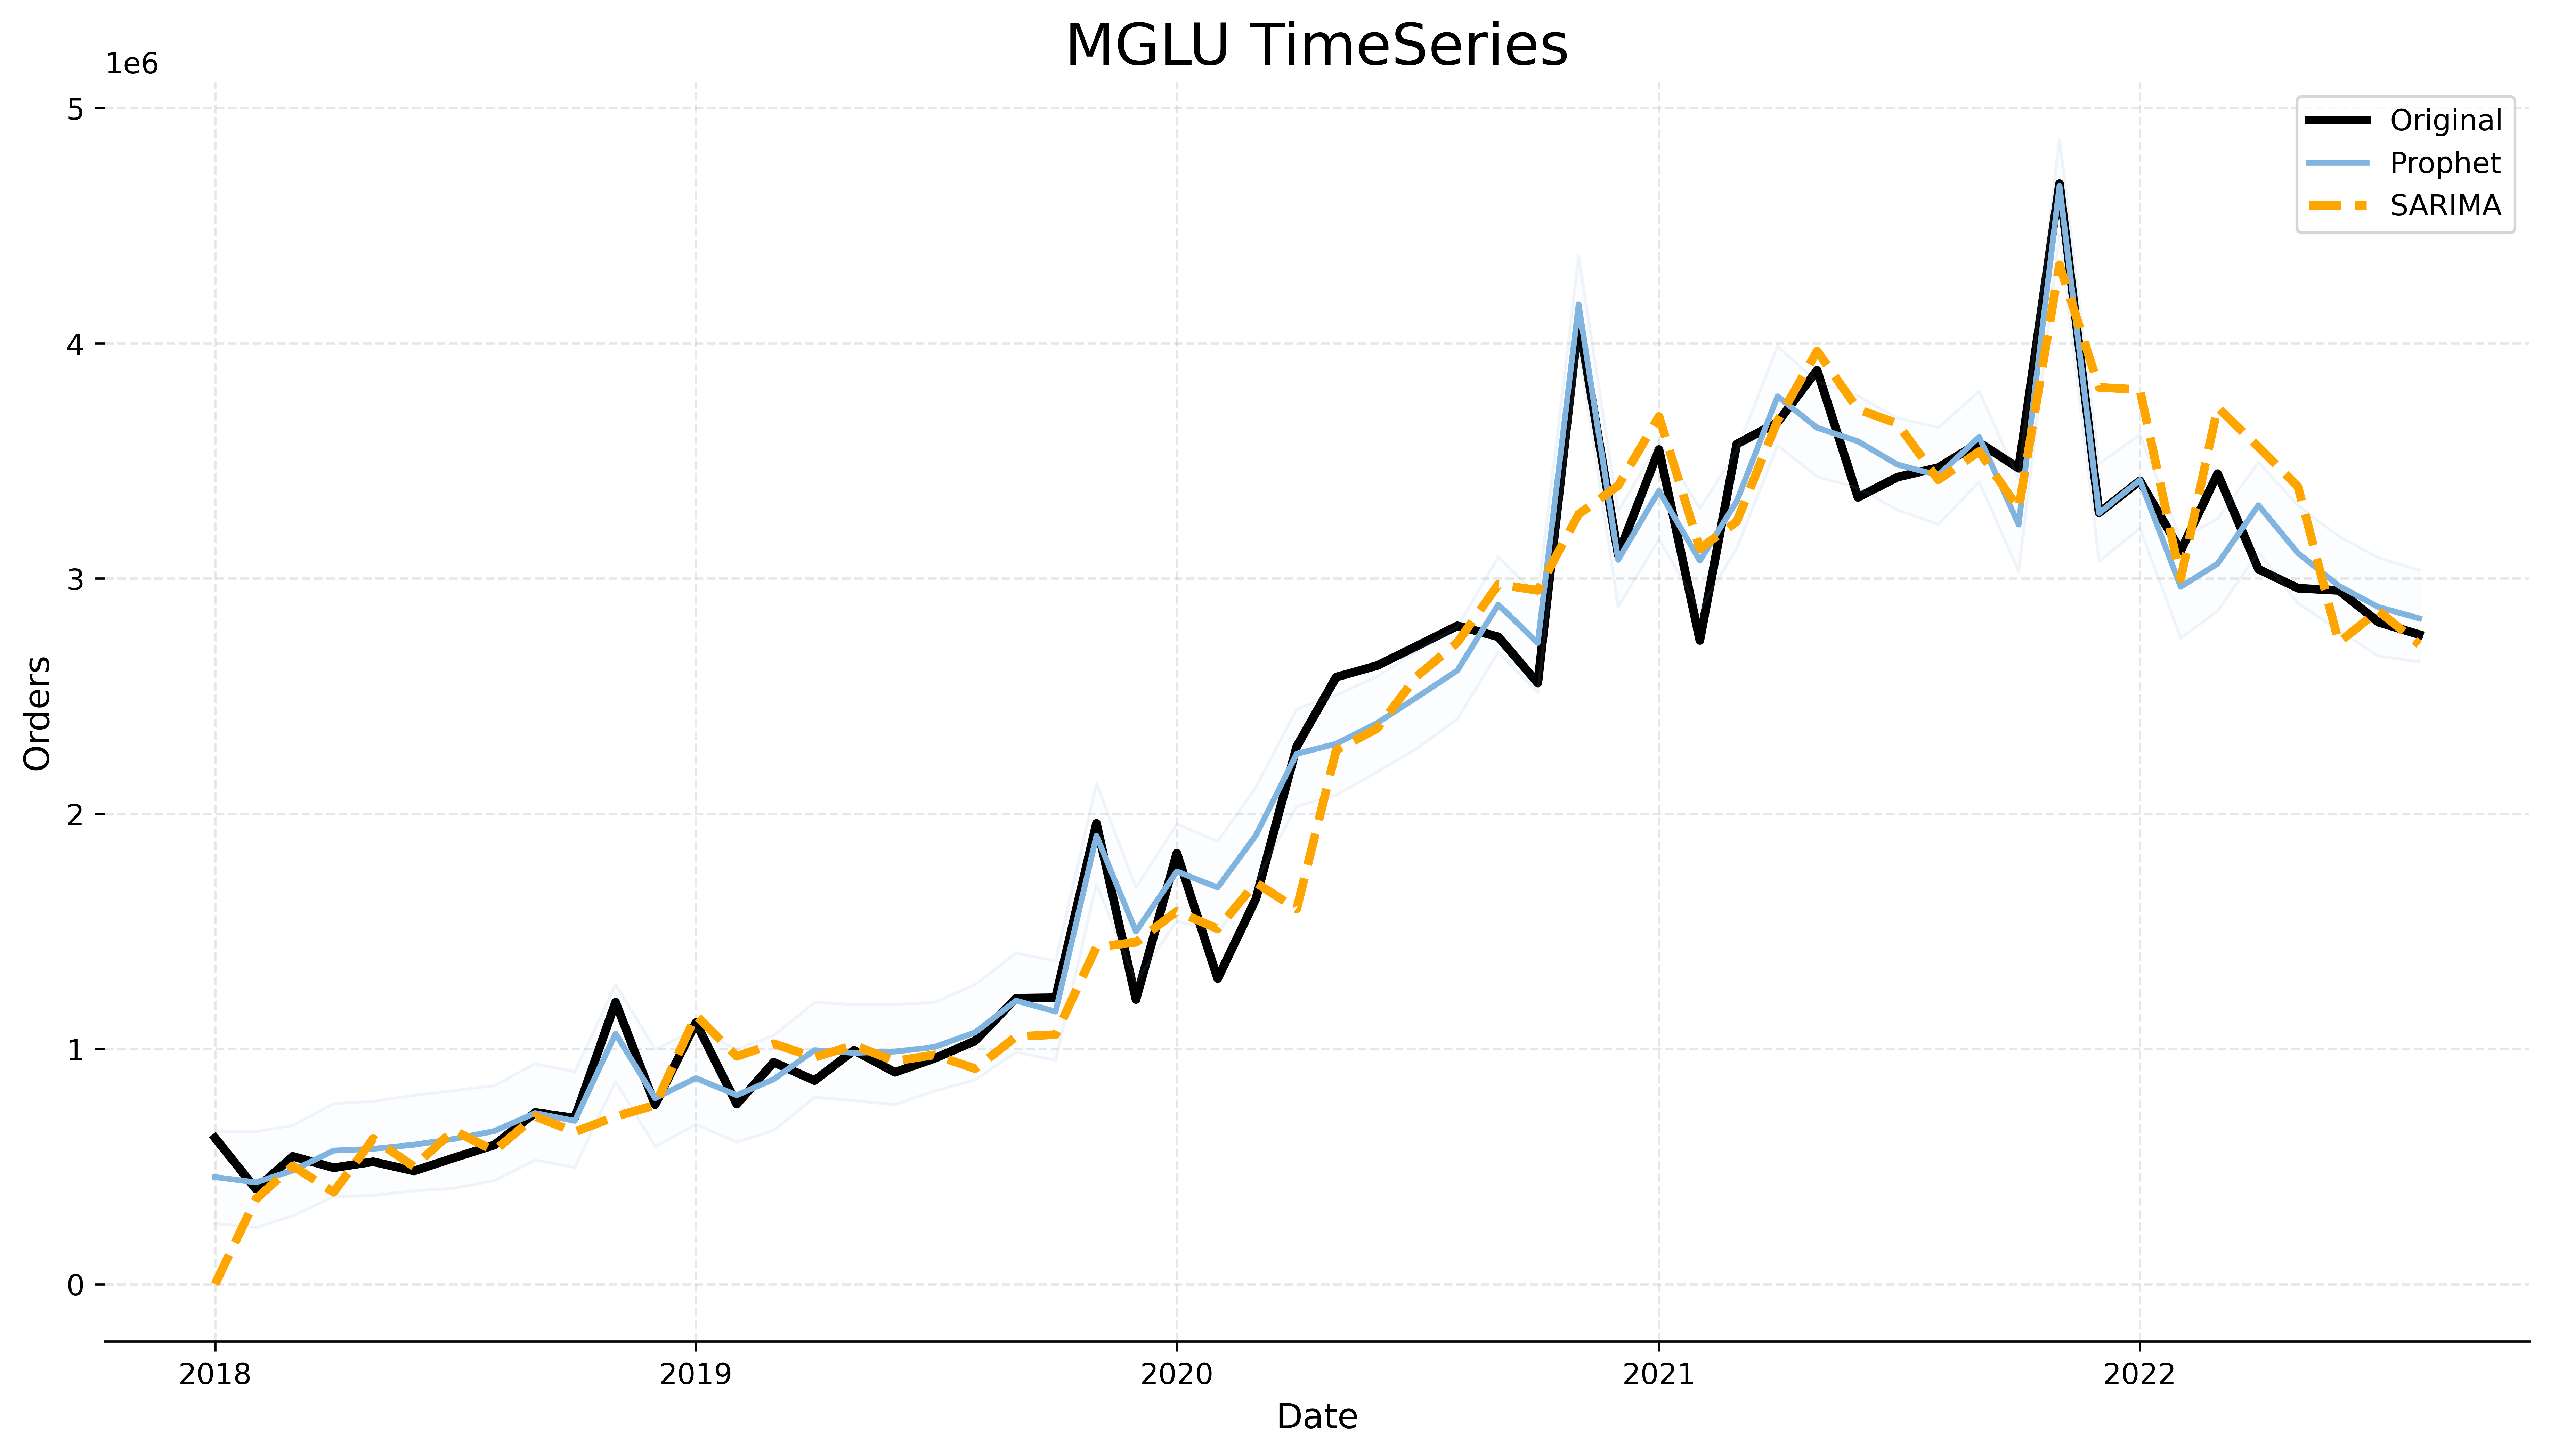

In [87]:
fig, ax = plt.subplots(ncols=1, figsize = (15,8), dpi=300)


df_full_2 = df_full[df_full['type'] == 'has_original_data']


plt.title("MGLU TimeSeries", fontsize=20)

sns.lineplot(data=df_full_2, x='ds', y='orders', label='Original', ax=ax, linewidth=3, color='black');

sns.lineplot(data=df_full_2, x='ds', y='yhat_prophet', label="Prophet", ax=ax, linestyle='-', color='#81b4de', linewidth=2);
sns.lineplot(data=df_full_2, x='ds', y='yhat_lower', ax=ax, linestyle='-', color='#81b4de', linewidth=1, alpha=0.1);
sns.lineplot(data=df_full_2, x='ds', y='yhat_upper', ax=ax, linestyle='-', color='#81b4de', linewidth=1, alpha=0.1);


plt.fill_between(data=df_full_2, x='ds', y1='yhat_lower', y2='yhat_upper', alpha=0.02, color='#81b4de')
sns.lineplot(data=df_full_2, x='ds', y='yhat_sarima', label="SARIMA", ax=ax, linestyle='--', color='orange', linewidth=3);


ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Orders", fontsize=12)
ax.grid(linestyle='--', alpha=0.3);

In [95]:
RMSE_prophet = np.sqrt(((df_full_2['yhat_prophet'] - df_full_2['orders'])**2).mean())

In [98]:
RMSE_sarima = np.sqrt(((df_full_2['yhat_sarima'] - df_full_2['orders'])**2).mean())

In [102]:
RMSE_sarima = round(RMSE_sarima, 2)
RMSE_prophet = round(RMSE_prophet, 2)

In [104]:
print(f"RMSE SARIMA: {RMSE_sarima} \nRMSE PROPHET: {RMSE_prophet}")

RMSE SARIMA: 284861.9 
RMSE PROPHET: 160345.73


# Predicting Future Dates

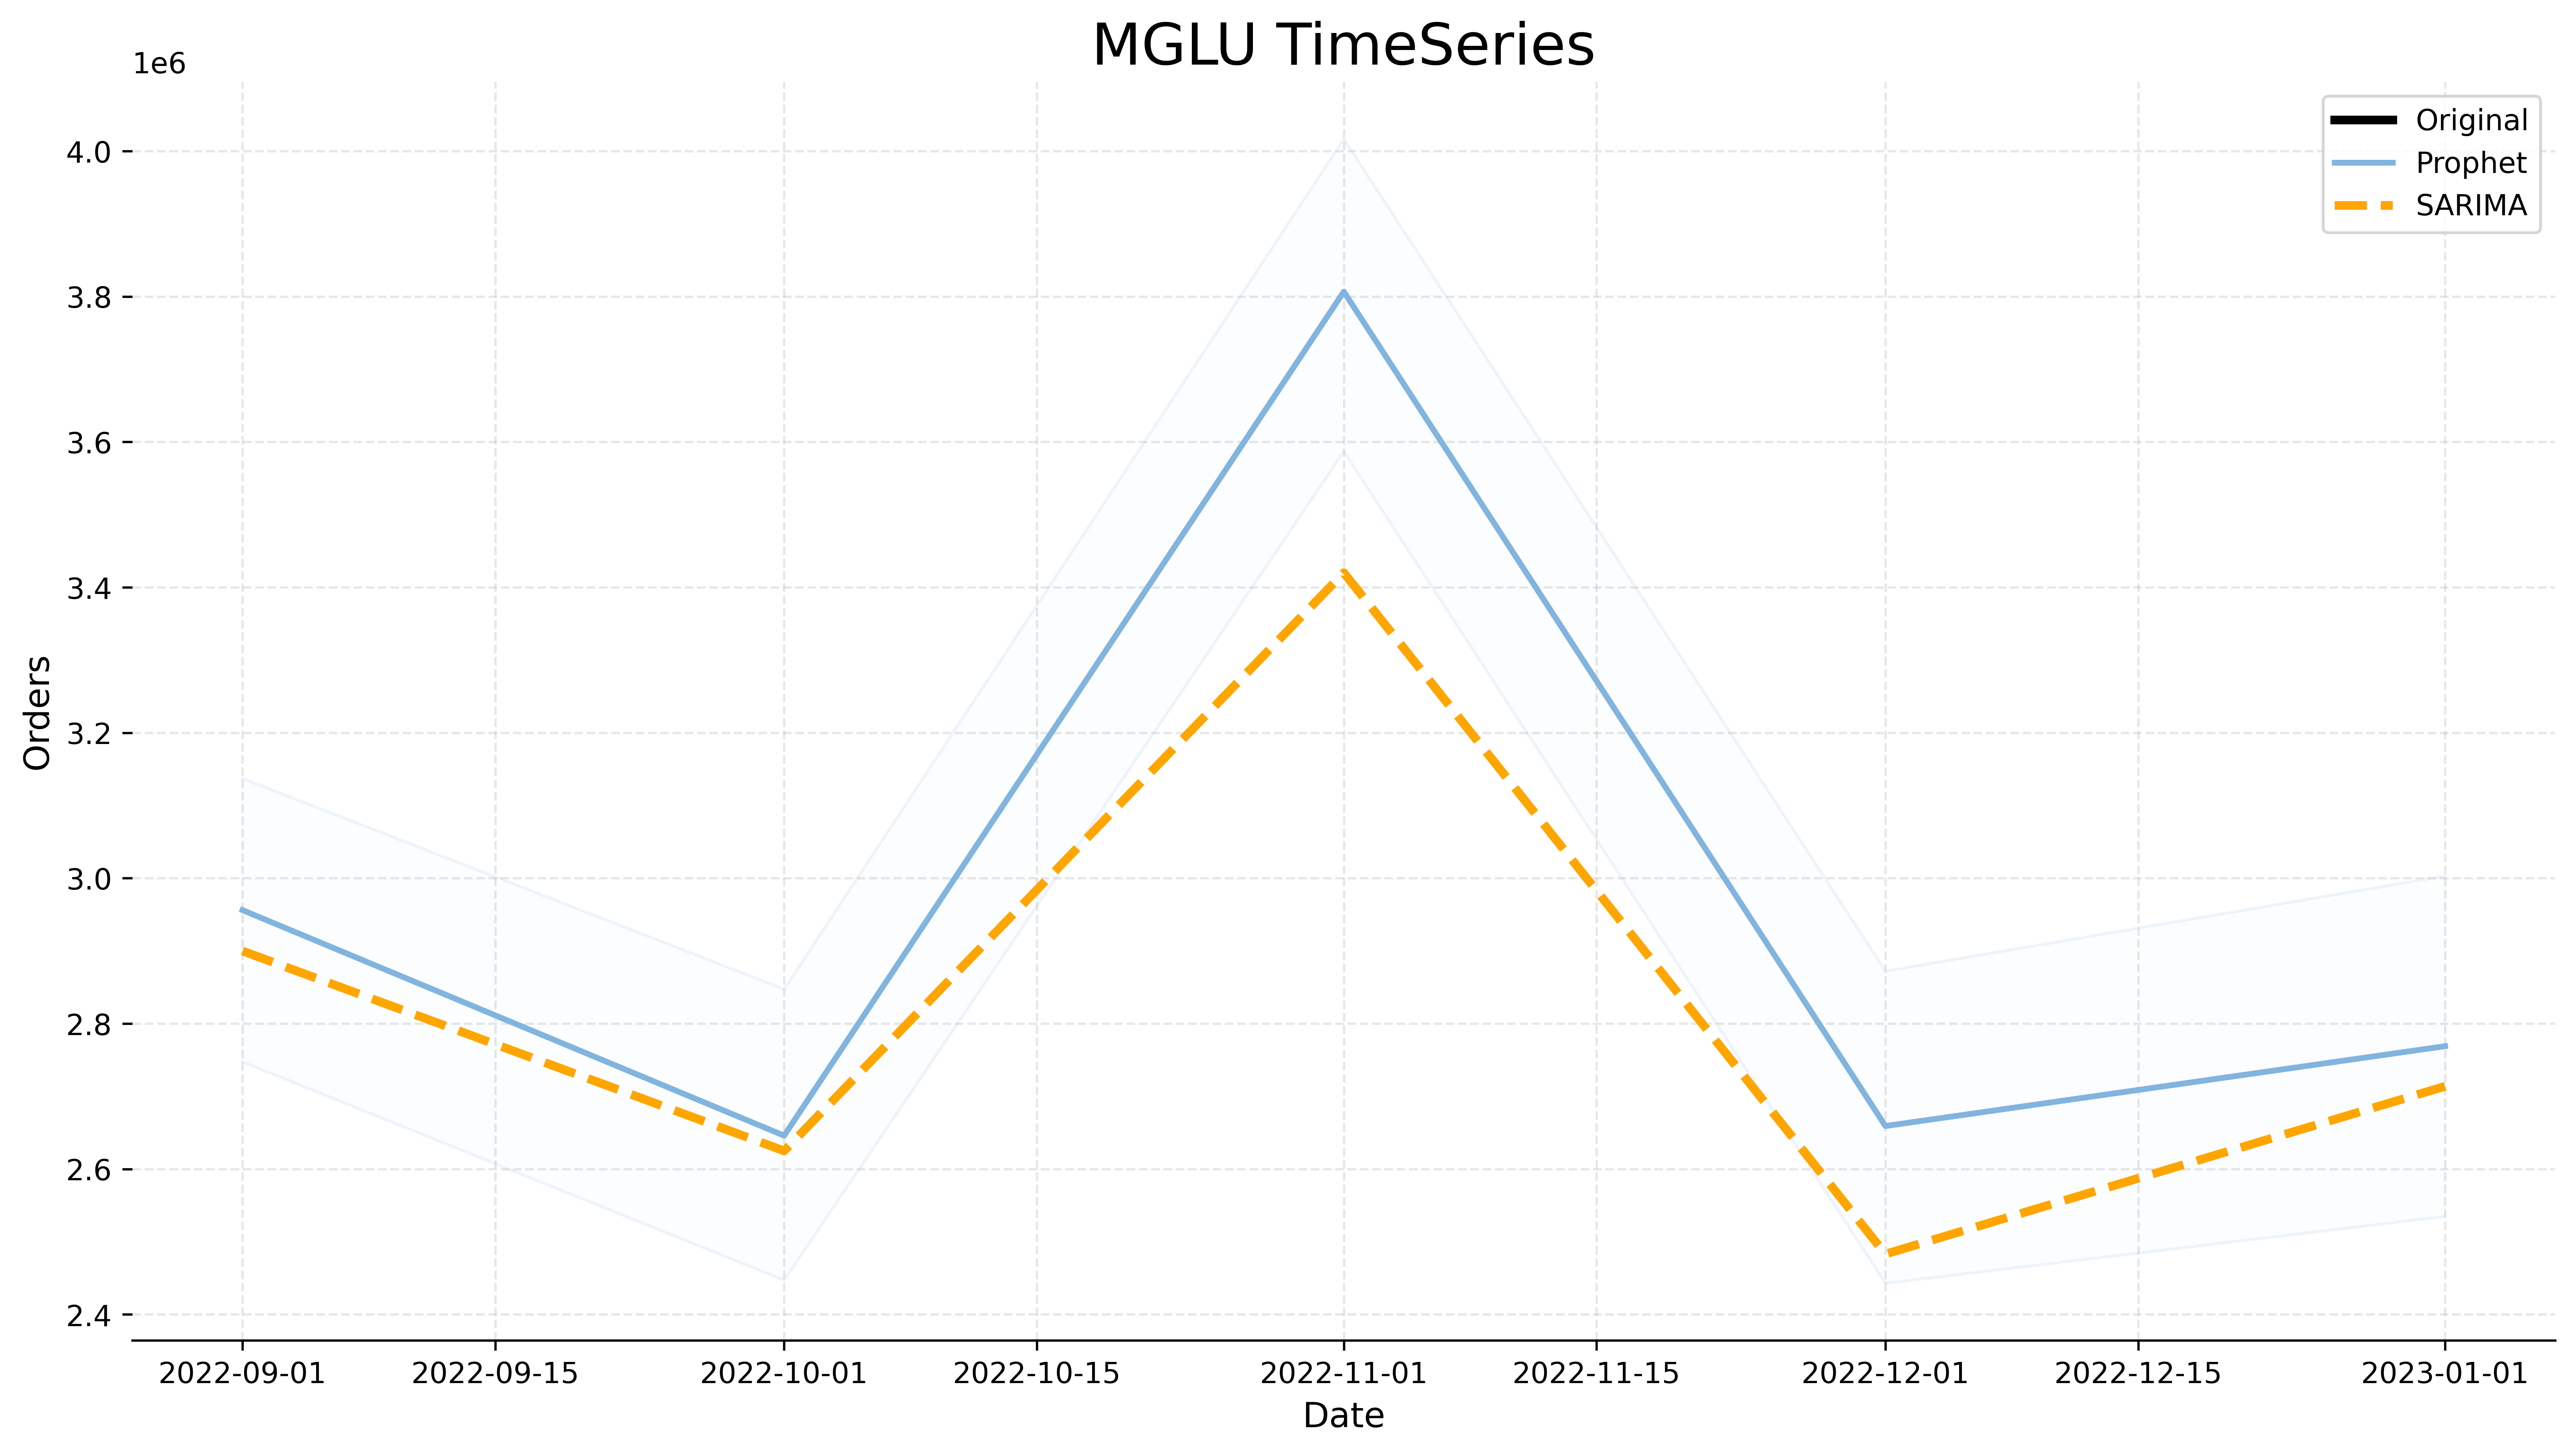

In [105]:
fig, ax = plt.subplots(ncols=1, figsize = (15,8), dpi=300)


df_full_2 = df_full[df_full['type'] == 'future']


plt.title("MGLU TimeSeries", fontsize=20)

sns.lineplot(data=df_full_2, x='ds', y='orders', label='Original', ax=ax, linewidth=3, color='black');

sns.lineplot(data=df_full_2, x='ds', y='yhat_prophet', label="Prophet", ax=ax, linestyle='-', color='#81b4de', linewidth=2);
sns.lineplot(data=df_full_2, x='ds', y='yhat_lower', ax=ax, linestyle='-', color='#81b4de', linewidth=1, alpha=0.1);
sns.lineplot(data=df_full_2, x='ds', y='yhat_upper', ax=ax, linestyle='-', color='#81b4de', linewidth=1, alpha=0.1);


plt.fill_between(data=df_full_2, x='ds', y1='yhat_lower', y2='yhat_upper', alpha=0.02, color='#81b4de')
sns.lineplot(data=df_full_2, x='ds', y='sarima_future_predictions', label="SARIMA", ax=ax, linestyle='--', color='orange', linewidth=3);


ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Orders", fontsize=12)
ax.grid(linestyle='--', alpha=0.3);